## Text Analytics on Subtitles 

### Approach 1

In [5]:
import os
import pandas as pd

# Define the folder containing the subtitle files
folder_path = 'Subtitles_28_nov_shortlist'

# Initialize an empty list to store all subtitles
all_subtitles = []

# Loop through all files in the folder
for idx, file_name in enumerate(os.listdir(folder_path)):
    if file_name.endswith('.vtt'):  # Ensure the file is a .vtt file
        video_id = f"v{idx + 1}"  # Assign a unique video ID (v1, v2, ...)
        file_path = os.path.join(folder_path, file_name)

        # Manually parse the .vtt file
        with open(file_path, 'r', encoding='utf-8') as file:
            lines = file.readlines()

            start_time, end_time, text = None, None, []
            for line in lines:
                line = line.strip()
                if '-->' in line:  # Time range line
                    if start_time and text:  # Save previous entry
                        all_subtitles.append({
                            'name':file_name,
                            'video_id': video_id,
                            'start_time': start_time,
                            'end_time': end_time,
                            'text': ' '.join(text)
                        })
                    # Extract start and end times
                    start_time, end_time = line.split(' --> ')
                    text = []  # Reset text for the next subtitle block
                elif line and not line.startswith('WEBVTT'):  # Subtitle text
                    text.append(line)

            # Append the last subtitle block
            if start_time and text:
                all_subtitles.append({
                    'video_id': video_id,
                    'start_time': start_time,
                    'end_time': end_time,
                    'text': ' '.join(text)
                })

# Create a DataFrame from the parsed subtitles
subtitle_df = pd.DataFrame(all_subtitles)




In [7]:
subtitle_df.head()

,name,video_id,start_time,end_time,text
0,Are All Dentists Con Artists？ - Joe List - I H...,v1,00:00:00.734,00:00:02.002,- I went to the doctor.
1,Are All Dentists Con Artists？ - Joe List - I H...,v1,00:00:02.002,00:00:03.236,"I was like, doc, I have a tinnitus or tinnitus,"
2,Are All Dentists Con Artists？ - Joe List - I H...,v1,00:00:03.236,00:00:04.104,whatever you guys are calling it.
3,Are All Dentists Con Artists？ - Joe List - I H...,v1,00:00:04.104,00:00:05.638,My ears are ringing
4,Are All Dentists Con Artists？ - Joe List - I H...,v1,00:00:05.638,00:00:07.307,"And then he said, okay, I'm going to test your..."


In [13]:
subtitle_df['name'].value_counts().shape

(38,)

In [9]:
len(subtitle_df)

21760

In [15]:
subtitle_df.to_csv("subtitle_df_28Nov.csv", index=False)

## Data Cleaning

In [17]:
# Convert the 'text' column to lowercase
subtitle_df['text'] = subtitle_df['text'].str.lower()

In [137]:
import re
from html import unescape

def clean_text_v2(text):
    # Convert HTML entities to their symbols
    text = unescape(text)  # Converts &lt; to <, &gt; to >, &nbsp; to a space, etc.

    # Replace &nbsp; specifically with a space
    text = text.replace('&nbsp;', ' ')
    text = text.replace('♪', '')
    

    # Remove HTML tags (e.g., <b>, </b>)
    text = re.sub(r'<.*?>', '', text)

    # Strip extra whitespace
    text = text.strip()

    return text

In [139]:
## Cleaning the text a bit
subtitle_df['text'] = subtitle_df['text'].apply(clean_text_v2)

In [141]:
## More text cleaning
import re

# Function to clean text by removing tags
def clean_tags(text):
    # Remove tags of the format <00:xx:xx.xxx><c>...</c>
    text = re.sub(r'<\d{2}:\d{2}:\d{2}\.\d{3}><c>.*?</c>', '', text)
    # Replace multiple spaces with a single space
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

# Apply the cleaning function to the 'text' column
subtitle_df['text'] = subtitle_df['text'].apply(clean_tags)

In [143]:
#subtitle_df.to_csv("subtitle_df2.csv", index=False)

## Defining our target variable - laughter

In [145]:
## making the 'laughter' column - our target variable

import re
import re

# Define laughter-related keywords
laughter_keywords = ["laugh", "cheer", "applause", "clapping", "chuckles", "giggle"]

# Compile laughter pattern regex
laughter_pattern = re.compile(r"(\[|\(|\{).*?(laugh|cheer|applause|giggle|clapping|chuckles).*?(\]|\)|\})", re.IGNORECASE)

# Function to detect laughter-related annotations
def detect_laughter(text):
    """
    Detect laughter-related annotations in the given text.

    Args:
    text (str): The input text to search for laughter-related content.

    Returns:
    int: 1 if laughter-related annotations or patterns are found, otherwise 0.
    """
    # Look for patterns like (audience laughing) or [CHEERS]
    matches = re.findall(r'\(.*?\)|\[.*?\]|\{.*?\}', text)  # Extract content in (), [], or {}
    for match in matches:
        if any(keyword in match.lower() for keyword in laughter_keywords):
            return 1

    # Check for laughter pattern using compiled regex
    if laughter_pattern.search(text):
        return 1

    return 0
    
# Initialize the laughter column
subtitle_df['laughter'] = 0

# Group by video_id to handle context within each video
for video_id, group in subtitle_df.groupby('video_id'):
    # Work with a copy of the group
    group = group.reset_index()  # Reset index for proper iteration

    for i in range(len(group)):
        if detect_laughter(group.loc[i, 'text']):  # If laughter-related annotation is found
            # Mark the current row and the preceding three rows
            start_idx = max(0, i - 3)
            group.loc[start_idx:i, 'laughter'] = 1

    # Update the original DataFrame
    subtitle_df.loc[group['index'], 'laughter'] = group['laughter'].values





In [147]:
subtitle_df.groupby(['name']).agg({'laughter':['sum','count']})[('laughter','sum')]/subtitle_df.groupby(['name']).agg({'laughter':['sum','count']})[('laughter','count')]

name
15 Minutes of Katt Williams_manual.en-US.vtt                                                                         0.183623
15 Minutes of Trevor Noah： Man of All Nations ｜ Netflix Is A Joke_manual.en-US.vtt                                   0.094737
A Man Of Average Intelligence. Zoltan Kaszas - Full Special_manual.en.vtt                                            0.223632
Amy Schumer- “Never Shake A Baby”- Full Special_manual.en-US.vtt                                                     0.450094
Are All Dentists Con Artists？ - Joe List - I Hate Myself_manual.en-US.vtt                                            0.480769
Bill Burr： “I’ll Never Own a Helicopter” - Full Special_manual.en-US.vtt                                             0.130342
Doing Magic For Drunk People. David Harris - Full Special_manual.en.vtt                                              0.552885
Hannibal Buress： Live from Chicago - Full Special_manual.en-US.vtt                                               

In [149]:
subtitle_df.to_csv("subtitle_laugh_28_Nov.csv", index=False)

## Feature Engineering

### Phonetic Features

In [151]:
!pip install pronouncing

In [153]:
## Computing phonetic features

import pronouncing

# Function to compute phonetic features
def compute_phonetic_features(text):
    words = text.split()
    if not words:
        return 0, 0, 0  # Return zeroes if no words

    # Get phonetic pronunciations for each word
    pronunciations = [pronouncing.phones_for_word(word.lower()) for word in words if pronouncing.phones_for_word(word.lower())]

    # Flatten the list of pronunciations
    pronunciations = [p[0] for p in pronunciations if p]

    # Initialize counts
    alliteration_count = 0
    assonance_count = 0
    consonance_count = 0

    vowels = "AEIOU"
    consonants = "BCDFGHJKLMNPQRSTVWXYZ"

    if pronunciations:
        # Alliteration: Compare the first sound of each word
        first_sounds = [p.split()[0] for p in pronunciations]
        alliteration_count = sum(first_sounds[i] == first_sounds[i - 1] for i in range(1, len(first_sounds)))

        # Assonance: Count matching vowel sounds across pronunciations
        assonance_count = sum(any(v in p for v in vowels) for p in pronunciations)

        # Consonance: Count matching consonant sounds across pronunciations
        consonance_count = sum(any(c in p for c in consonants) for p in pronunciations)

    return alliteration_count, assonance_count, consonance_count

# Apply phonetic features to each row
subtitle_df[['alliteration', 'assonance', 'consonance']] = subtitle_df['text'].apply(
    lambda x: pd.Series(compute_phonetic_features(x))
)




### Ambiguity Features

In [ ]:
pip install nltk

In [51]:
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')  # Optional for multilingual WordNet support

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/amansharma/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/amansharma/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [155]:
## word senses and antonyms

from nltk.corpus import wordnet

# Function to compute ambiguity features
def compute_ambiguity_features(text):
    words = text.split()
    if not words:
        return 0, 0  # Return zeroes if no words

    total_senses = 0
    antonym_count = 0

    for word in words:
        synsets = wordnet.synsets(word)
        total_senses += len(synsets)  # Count senses for the word

        # Check for antonyms
        for synset in synsets:
            for lemma in synset.lemmas():
                if lemma.antonyms():
                    antonym_count += 1
                    break  # Count each word's antonym occurrence only once

    # Calculate average senses per word
    avg_senses = total_senses / len(words) if words else 0

    return avg_senses, antonym_count

# Apply the function to each row in the DataFrame
subtitle_df[['avg_senses', 'antonym_count']] = subtitle_df['text'].apply(
    lambda x: pd.Series(compute_ambiguity_features(x))
)



A word sense is a specific meaning or interpretation of a word within a given context. In computational linguistics, word senses are the different meanings of a word as defined in a lexical database like WordNet.



*   Words with more senses have multiple meanings, leading to potential ambiguity in interpretation.
*   Sentences composed of such words can leave room for wordplay, puns, or double meanings, which are often key elements in humor.

In [55]:
subtitle_df.head()

,name,video_id,start_time,end_time,text,laughter,alliteration,assonance,consonance,avg_senses,antonym_count
0,Are All Dentists Con Artists？ - Joe List - I H...,v1,00:00:00.734,00:00:02.002,- i went to the doctor.,0,0,4,4,5.666667,5.0
1,Are All Dentists Con Artists？ - Joe List - I H...,v1,00:00:02.002,00:00:03.236,"i was like, doc, i have a tinnitus or tinnitus,",0,0,7,7,5.200000,4.0
2,Are All Dentists Con Artists？ - Joe List - I H...,v1,00:00:03.236,00:00:04.104,whatever you guys are calling it.,0,0,5,5,8.166667,1.0
3,Are All Dentists Con Artists？ - Joe List - I H...,v1,00:00:04.104,00:00:05.638,my ears are ringing,0,0,4,4,7.000000,1.0
4,Are All Dentists Con Artists？ - Joe List - I H...,v1,00:00:05.638,00:00:07.307,"and then he said, okay, i'm going to test your...",0,1,8,8,4.909091,5.0


In [222]:
subtitle_df.head()

,name,video_id,start_time,end_time,text,laughter,alliteration,assonance,consonance,avg_senses,...,profanity_flag,sentiment_compound,sense_combination,sense_farmost,sense_closest,question_count,exclamation_count,pause_count,entity_count,proper_noun_count
0,Are All Dentists Con Artists？ - Joe List - I H...,v1,00:00:00.734,00:00:02.002,- i went to the doctor.,0,0,4,4,5.666667,...,0,0.0000,5.347108,0.058824,0.333333,0,0,0,0,0
1,Are All Dentists Con Artists？ - Joe List - I H...,v1,00:00:02.002,00:00:03.236,"i was like, doc, i have a tinnitus or tinnitus,",0,0,7,7,5.200000,...,0,0.3612,2.995732,0.071429,1.000000,0,0,0,1,1
2,Are All Dentists Con Artists？ - Joe List - I H...,v1,00:00:03.236,00:00:04.104,whatever you guys are calling it.,0,0,5,5,8.166667,...,0,0.0000,4.976734,0.043478,0.333333,0,0,0,0,0
3,Are All Dentists Con Artists？ - Joe List - I H...,v1,00:00:04.104,00:00:05.638,my ears are ringing,0,0,4,4,7.000000,...,0,0.0000,3.806662,0.052632,0.333333,0,0,0,0,0
4,Are All Dentists Con Artists？ - Joe List - I H...,v1,00:00:05.638,00:00:07.307,"and then he said, okay, i'm going to test your...",0,1,8,8,4.909091,...,0,0.2263,12.670561,0.050000,0.333333,0,0,0,0,0


### Checking for use of entities in text

In [61]:
## for specifity
!pip install spacy
!python -m spacy download en_core_web_sm

  Using cached numpy-2.0.2-cp311-cp311-macosx_14_0_arm64.whl.metadata (60 kB)
Using cached numpy-2.0.2-cp311-cp311-macosx_14_0_arm64.whl (5.3 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
whisper-at 0.5 requires triton==2.0.0, which is not installed.
streamlit 1.30.0 requires numpy<2,>=1.19.3, but you have numpy 2.0.2 which is incompatible.
streamlit 1.30.0 requires packaging<24,>=16.8, but you have packaging 24.1 which is incompatible.
contourpy 1.2.0 requires numpy<2.0,>=1.20, but you have numpy 2.0.2 which is incompatible.
matplotlib 3.8.0 requires numpy<2,>=1.21, but you have numpy 2.0.2 which is incompatible.
wrds 3.2.0 requires numpy<1.27,>=1.26, but you have numpy 2.0.2 which is incompatible.
wrds 3.

In [326]:
combined_data = subtitle_df
import spacy

# Load the SpaCy model
nlp = spacy.load("en_core_web_sm")

# Function to extract named entities
def extract_entities(text):
    doc = nlp(text)
    entities = [(ent.text, ent.label_) for ent in doc.ents]  # Extract entity text and its type
    return entities  # Return list of entities

def extract_labels(text):
    doc = nlp(text)
    labels = [(ent.label_) for ent in doc.ents]  # Extract entity text and its type
    return labels  # Return list of entities

# Apply the function to extract entities
combined_data['specificity'] = combined_data['text'].apply(extract_entities)
combined_data['labels'] = combined_data['text'].apply(extract_labels)


**Specificity** in text refers to the level of detail or concreteness in the words. For humor analysis, more specific terms (e.g., named entities like proper nouns, locations, or unique references) can often contribute to humor.

In [331]:
from collections import Counter

# Flatten the list of entity types from the 'specificity' column
entity_types = [entity[1] for entities in combined_data['specificity'] for entity in entities]

# Count the frequency of each entity type
entity_type_counts = Counter(entity_types)

# Convert to a DataFrame for better readability (optional)
entity_type_counts_df = pd.DataFrame(entity_type_counts.items(), columns=['Entity Type', 'Frequency'])

# Display the results
entity_type_counts_df



,Entity Type,Frequency
0,ORG,145
1,TIME,231
2,MONEY,107
3,DATE,613
4,CARDINAL,744
5,GPE,412
6,ORDINAL,199
7,PERSON,450
8,LOC,27
9,QUANTITY,36


In [332]:

combined_data[combined_data['labels'].apply(lambda x: 'PERSON' in x)].head(10)


,name,video_id,start_time,end_time,text,laughter,alliteration,assonance,consonance,avg_senses,...,prev_pause_count_5,prev_entity_count_5,prev_proper_noun_count_5,prev_glove_vector_5,cosine_similarities,cosine_sim_1,cosine_sim_2,cosine_sim_3,cosine_sim_4,cosine_sim_5
308,Jourdain Fisher Stand-Up_manual.en.vtt,v2,00:02:06.926,00:02:10.329,i've done my research on white people. mm-hmm.,0,0,6,6,6.125000,...,0.0,0.0,0.0,"[-0.071421795, 0.1682258, 0.066487, -0.208546,...","[0.64093405, 0.7594315, 0.33403242, 0.8162576,...",0.640934,0.759431,0.334032,0.816258,0.733090
321,Jourdain Fisher Stand-Up_manual.en.vtt,v2,00:02:40.393,00:02:43.129,"oh, just save us, khaleesi.""",1,0,2,2,4.400000,...,0.0,0.0,0.0,"[-0.24910043, 0.09102056, 0.05403671, -0.02240...","[0.6657561, 0.6749533, 0.3181276, 0.0, 0.6186186]",0.665756,0.674953,0.318128,0.000000,0.618619
332,Jourdain Fisher Stand-Up_manual.en.vtt,v2,00:03:12.524,00:03:14.160,i'm tellin' ya.,1,0,2,2,0.000000,...,0.0,0.0,0.0,"[-0.0539609, -0.059904665, -0.26799902, 0.1894...","[0.0, 0.0, 0.0, 0.0, 0.0]",0.000000,0.000000,0.000000,0.000000,0.000000
338,Jourdain Fisher Stand-Up_manual.en.vtt,v2,00:03:30.909,00:03:32.511,"nah, i've actually been hanging out",0,0,5,5,8.666667,...,0.0,0.0,0.0,"[0.13130066, -0.027582401, -0.092530206, -0.09...","[0.7391254, 0.24867284, 0.78172356, 0.66291016...",0.739125,0.248673,0.781724,0.662910,0.374583
401,Jourdain Fisher Stand-Up_manual.en.vtt,v2,00:06:00.927,00:06:03.563,jourdain fisher right there!,0,0,2,2,9.500000,...,0.0,0.0,2.0,"[-0.070235, -0.035861712, -0.04503342, -0.1873...","[0.0, 0.32135528, 0.17022671, 0.14468926, 0.51...",0.000000,0.321355,0.170227,0.144689,0.513728
411,Ricky Gervais Out Of England 2 - The Stand Up ...,v3,00:00:31.874,00:00:35.379,mr. ricky gervais!,1,0,2,2,0.333333,...,0.0,0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.22453174, 0.21599573, 0.23995754, 0.0, 0.0]",0.224532,0.215996,0.239958,0.000000,0.000000
434,Ricky Gervais Out Of England 2 - The Stand Up ...,v3,00:01:38.471,00:01:42.906,"if i suddenly start talking like paula abdul, ...",0,1,9,9,5.363636,...,0.0,0.0,0.0,"[-0.16415143, 0.07252557, -0.30732128, -0.1010...","[0.6665957, 0.67089075, 0.77660936, 0.9067853,...",0.666596,0.670891,0.776609,0.906785,0.645242
543,Ricky Gervais Out Of England 2 - The Stand Up ...,v3,00:06:11.160,00:06:14.962,"did you make a tree fall on steve baxter's car?""",0,0,9,9,12.700000,...,0.0,0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.8307432, 0.6023945, 0.72809124, 0.7514467, ...",0.830743,0.602395,0.728091,0.751447,0.000000
544,Ricky Gervais Out Of England 2 - The Stand Up ...,v3,00:06:14.996,00:06:16.764,"""there's a lot of steve baxters.""",0,0,4,4,2.666667,...,0.0,0.0,0.0,"[-0.1261425, 0.11259999, -0.013957831, -0.1695...","[0.8260223, 0.7401767, 0.5209887, 0.6073743, 0...",0.826022,0.740177,0.520989,0.607374,0.736210
545,Ricky Gervais Out Of England 2 - The Stand Up ...,v3,00:06:16.798,00:06:20.500,"""steve baxter, 2 acacia road, hounslow.",0,0,1,1,0.500000,...,0.0,0.0,0.0,"[-0.20673, 0.15939501, 0.024705, 0.20285401, 0...","[0.17715228, 0.23928711, 0.16856378, 0.1177065...",0.177152,0.239287,0.168564,0.117707,0.148060


In [333]:
combined_data[combined_data['labels'].apply(lambda x: 'CARDINAL' in x)].head(10)

,name,video_id,start_time,end_time,text,laughter,alliteration,assonance,consonance,avg_senses,...,prev_pause_count_5,prev_entity_count_5,prev_proper_noun_count_5,prev_glove_vector_5,cosine_similarities,cosine_sim_1,cosine_sim_2,cosine_sim_3,cosine_sim_4,cosine_sim_5
159,Are All Dentists Con Artists？ - Joe List - I H...,v1,00:04:30.003,00:04:31.537,"it's not like i said, 75,000.",0,0,4,4,2.666667,...,0.0,0.0,0.0,"[-0.18484299, 0.18605176, 0.036509253, -0.0263...","[0.9285639, 0.7545378, 0.91155726, 0.0, 0.7647...",0.928564,0.754538,0.911557,0.000000,0.764733
178,Are All Dentists Con Artists？ - Joe List - I H...,v1,00:05:07.040,00:05:07.707,i've had like nine in the last three weeks.,1,0,8,8,7.222222,...,0.0,0.0,0.0,"[0.1535665, 0.0903245, -0.013025001, -0.309465...","[0.7238953, 0.67191535, 0.72784257, 0.75081545...",0.723895,0.671915,0.727843,0.750815,0.442093
217,Are All Dentists Con Artists？ - Joe List - I H...,v1,00:06:13.206,00:06:16.342,"i was like, it cost me $3,500 to fix two teeth",1,1,9,9,4.636364,...,0.0,0.0,0.0,"[-0.042648505, 0.041340005, -0.10810675, 0.016...","[0.8657675, 0.82824636, 0.89151174, 0.86007714...",0.865767,0.828246,0.891512,0.860077,0.832704
230,Are All Dentists Con Artists？ - Joe List - I H...,v1,00:06:43.836,00:06:45.471,"give me two eye exams, double check both eyes.",0,0,7,7,12.777778,...,0.0,0.0,0.0,"[-0.2889273, 0.09023029, -0.05932228, -0.10783...","[0.76413226, 0.6005163, 0.84773445, 0.7908015,...",0.764132,0.600516,0.847734,0.790802,0.824078
257,Are All Dentists Con Artists？ - Joe List - I H...,v1,00:07:37.490,00:07:38.324,"you did, you had two.",1,1,3,3,3.800000,...,0.0,0.0,0.0,"[-0.26546872, 0.16531412, -0.142056, 0.0453266...","[0.83705056, 0.8985628, 0.0, 0.61078894, 0.906...",0.837051,0.898563,0.000000,0.610789,0.906450
258,Are All Dentists Con Artists？ - Joe List - I H...,v1,00:07:38.324,00:07:39.459,i thought you had two.,1,0,4,4,8.000000,...,0.0,0.0,0.0,"[-0.41355, 0.076012, 0.099178, -0.01195, 0.018...","[0.9562767, 0.7816298, 0.8403874, 0.0, 0.6057079]",0.956277,0.781630,0.840387,0.000000,0.605708
408,Ricky Gervais Out Of England 2 - The Stand Up ...,v3,00:00:23.726,00:00:25.562,"winner of three golden globes,",0,0,4,4,2.400000,...,0.0,0.0,0.0,"[-0.18029569, -0.08444129, -0.13684072, 0.0687...","[0.0, 0.0, 0.63506573, 0.6415204, 0.48117262]",0.000000,0.000000,0.635066,0.641520,0.481173
409,Ricky Gervais Out Of England 2 - The Stand Up ...,v3,00:00:25.596,00:00:29.201,"two prime time emmys and seven baftas,",1,0,6,6,4.857143,...,0.0,0.0,0.0,"[-0.0866535, -0.08255066, 0.07369008, -0.28604...","[0.7380012, 0.0, 0.0, 0.59157723, 0.6263788]",0.738001,0.000000,0.000000,0.591577,0.626379
477,Ricky Gervais Out Of England 2 - The Stand Up ...,v3,00:03:26.327,00:03:29.361,"10,000 seats sold out well in advance,",0,1,5,5,10.285714,...,1.0,0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.39514568, 0.62356275, 0.35153076, 0.0, 0.0]",0.395146,0.623563,0.351531,0.000000,0.000000
545,Ricky Gervais Out Of England 2 - The Stand Up ...,v3,00:06:16.798,00:06:20.500,"""steve baxter, 2 acacia road, hounslow.",0,0,1,1,0.500000,...,0.0,0.0,0.0,"[-0.20673, 0.15939501, 0.024705, 0.20285401, 0...","[0.17715228, 0.23928711, 0.16856378, 0.1177065...",0.177152,0.239287,0.168564,0.117707,0.148060


In [334]:
combined_data[combined_data['labels'].apply(lambda x: 'GPE' in x)].head(10)

,name,video_id,start_time,end_time,text,laughter,alliteration,assonance,consonance,avg_senses,...,prev_pause_count_5,prev_entity_count_5,prev_proper_noun_count_5,prev_glove_vector_5,cosine_similarities,cosine_sim_1,cosine_sim_2,cosine_sim_3,cosine_sim_4,cosine_sim_5
222,Are All Dentists Con Artists？ - Joe List - I H...,v1,00:06:24.717,00:06:27.653,"an eye exam cost in new york city, $75.",1,0,7,7,3.666667,...,0.0,2.0,0.0,"[-0.06833173, 0.15553322, -0.3424652, -0.10407...","[0.6150707, 0.0, 0.59355426, 0.38148493, 0.712...",0.615071,0.000000,0.593554,0.381485,0.712412
261,Jourdain Fisher Stand-Up_manual.en.vtt,v2,00:00:00.900,00:00:02.835,"-what's up, new york? hey.",0,0,1,1,2.400000,...,0.0,0.0,0.0,"[-0.370242, 0.291591, -0.1445584, -0.17361839,...","[0.0, 0.0, 0.38163853, 0.41557804, 0.5001069]",0.000000,0.000000,0.381639,0.415578,0.500107
279,Jourdain Fisher Stand-Up_manual.en.vtt,v2,00:00:51.350,00:00:54.520,because i grew up on the d.a.r.e. program.,1,0,6,6,4.125000,...,0.0,0.0,0.0,"[-0.0539609, -0.059904665, -0.26799902, 0.1894...","[0.89100534, 0.8213501, 0.8080706, 0.4493239, ...",0.891005,0.821350,0.808071,0.449324,0.322844
282,Jourdain Fisher Stand-Up_manual.en.vtt,v2,00:00:59.692,00:01:02.028,"the d.a.r.e. program was effective, man,",0,0,3,3,4.000000,...,0.0,0.0,0.0,"[-0.052435942, 0.18035829, -0.11558084, 0.0659...","[0.66333866, 0.28865868, 0.70683825, 0.6033726...",0.663339,0.288659,0.706838,0.603373,0.537731
368,Jourdain Fisher Stand-Up_manual.en.vtt,v2,00:04:47.120,00:04:49.422,"like, i'm from a place called greensboro, nort...",1,0,6,6,8.444444,...,0.0,0.0,0.0,"[-0.032909174, 0.15741889, -0.18153588, -0.080...","[0.7414787, 0.7727486, 0.7044817, 0.69940567, ...",0.741479,0.772749,0.704482,0.699406,0.676083
370,Jourdain Fisher Stand-Up_manual.en.vtt,v2,00:04:51.390,00:04:53.326,"and in greensboro, we had a planetarium.",1,0,5,5,4.714286,...,0.0,0.0,0.0,"[-0.09271129, 0.16625573, -0.05791071, -0.1780...","[0.45556647, 0.8277601, 0.84879816, 0.89227456...",0.455566,0.827760,0.848798,0.892275,0.865143
410,Ricky Gervais Out Of England 2 - The Stand Up ...,v3,00:00:29.235,00:00:31.839,"all the way from england,",1,0,4,4,3.200000,...,0.0,0.0,1.0,"[-0.03560267, -0.021839634, 0.046318997, -0.52...","[0.66859686, 0.67553985, 0.0, 0.0, 0.6609302]",0.668597,0.675540,0.000000,0.000000,0.660930
417,Ricky Gervais Out Of England 2 - The Stand Up ...,v3,00:00:58.753,00:01:01.523,"thank you. hello, chicago.",1,0,1,1,0.250000,...,0.0,0.0,0.0,"[0.02392667, 0.0029799987, 0.013386662, -0.078...","[0.12920696, 0.12234528, 0.0, 0.0, 0.22759889]",0.129207,0.122345,0.000000,0.000000,0.227599
467,Ricky Gervais Out Of England 2 - The Stand Up ...,v3,00:02:58.837,00:03:02.506,"i had a gig in dublin a couple of months ago, ...",1,0,10,10,5.166667,...,0.0,0.0,0.0,"[-0.009130001, -0.19064, -0.03926, -0.0683015,...","[0.6130949, 0.59506476, 0.7819087, 0.7074974, ...",0.613095,0.595065,0.781909,0.707497,0.559985
468,Ricky Gervais Out Of England 2 - The Stand Up ...,v3,00:03:02.541,00:03:04.608,"- and as you know, dublin is in ireland... - (...",1,0,7,7,2.461538,...,0.0,0.0,0.0,"[-0.20235334, 0.13695617, -0.14361423, -0.0776...","[0.75014776, 0.5245292, 0.5173645, 0.7280799, ...",0.750148,0.524529,0.517365,0.728080,0.649699


In [335]:
# Step 1: Get all unique labels
unique_labels = set(label for labels_list in combined_data['labels'] for label in labels_list)

# Step 2: Create one-hot encoded columns
for label in unique_labels:
    combined_data[f'label_{label}'] = combined_data['labels'].apply(lambda x: 1 if label in x else 0)


/var/folders/98/9mpqczkx3011qp7wbmnvfmb00000gn/T/ipykernel_11508/2479740620.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  combined_data[f'label_{label}'] = combined_data['labels'].apply(lambda x: 1 if label in x else 0)
/var/folders/98/9mpqczkx3011qp7wbmnvfmb00000gn/T/ipykernel_11508/2479740620.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  combined_data[f'label_{label}'] = combined_data['labels'].apply(lambda x: 1 if label in x else 0)
/var/folders/98/9mpqczkx3011qp7wbmnvfmb00000gn/T/ipykernel_11508/2479740620.py:6: 

### Use of profanity

In [233]:
!pip install better_profanity

In [336]:
from better_profanity import profanity

# Example text
text = "This is damn funny and a bit shitty!"

# Censor or check for profanity
contains_profanity = profanity.contains_profanity(text)  # Returns True if profanity detected
print("Contains Profanity:", contains_profanity)

# Optionally censor the text
censored_text = profanity.censor(text)
print("Censored Text:", censored_text)

Contains Profanity: True
Censored Text: This is **** funny and a bit ****!


In [337]:


# Apply profanity detection to the 'text' column and create a 1/0 indicator
combined_data['profanity_flag'] = combined_data['text'].apply(lambda x: 1 if profanity.contains_profanity(x) else 0)

combined_data[combined_data['profanity_flag']==1].head()

,name,video_id,start_time,end_time,text,laughter,alliteration,assonance,consonance,avg_senses,...,label_LOC,label_PERSON,label_MONEY,label_GPE,label_DATE,label_CARDINAL,label_ORG,label_ORDINAL,label_LAW,label_PRODUCT
10,Are All Dentists Con Artists？ - Joe List - I H...,v1,00:00:17.884,00:00:19.119,i'm hearing shit that's not even in the room.,1,0,8,8,4.666667,...,0,0,0,0,0,0,0,0,0,0
46,Are All Dentists Con Artists？ - Joe List - I H...,v1,00:01:11.538,00:01:13.273 align:start size:88% position:13%,"could be your small dick also, i don't know.",1,0,7,7,3.666667,...,0,0,0,0,0,0,0,0,0,0
56,Are All Dentists Con Artists？ - Joe List - I H...,v1,00:01:29.556,00:01:32.358,and i was like you have big hairs in your nose...,1,0,11,11,7.750000,...,0,0,0,0,0,0,0,0,0,0
74,Are All Dentists Con Artists？ - Joe List - I H...,v1,00:02:07.127,00:02:08.761,put a little dog shit on your lip.,1,0,7,7,6.000000,...,0,0,0,0,0,0,0,0,0,0
77,Are All Dentists Con Artists？ - Joe List - I H...,v1,00:02:13.099,00:02:14.100 align:start size:88% position:13%,scoop a little dog shit on your upper lip.,0,0,8,8,5.777778,...,0,0,0,0,0,0,0,0,0,0


In [338]:
combined_data.groupby(['profanity_flag']).agg({'laughter':'sum','name':'count'})

,laughter,name
profanity_flag,,
0,7368,20195
1,447,1527


In [339]:
combined_data.to_csv('data_w_profanity_tag.csv')

### Computing sentiment scores

In [340]:
## sentiment score
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk

# Download VADER lexicon
nltk.download('vader_lexicon')

# Initialize VADER
sia = SentimentIntensityAnalyzer()

# Compute sentiment scores
sentiment_scores = combined_data['text'].apply(sia.polarity_scores)

# Extract specific sentiment components
combined_data['sentiment_compound'] = sentiment_scores.apply(lambda x: x['compound'])




[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/amansharma/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


### More ambiguity features

In [341]:
## sense combination

import spacy
from nltk.corpus import wordnet
import numpy as np

# Load SpaCy model
nlp = spacy.load("en_core_web_sm")

# Function to compute sense combination
def compute_sense_combination(text):
    doc = nlp(text)
    sense_product = 1  # Initialize product of senses

    for token in doc:
        # Process only Nouns, Verbs, Adjectives, and Adverbs
        if token.pos_ in ["NOUN", "VERB", "ADJ", "ADV"]:
            senses = wordnet.synsets(token.text)  # Get senses for the word
            if senses:  # Only consider words with senses in WordNet
                sense_product *= len(senses)  # Multiply by the number of senses

    # Compute logarithmic product
    if sense_product > 1:
        sense_combination = np.log(sense_product)
    else:
        sense_combination = 0  # If no senses found, return 0

    return sense_combination

# Apply the function to each row
combined_data['sense_combination'] = combined_data['text'].apply(compute_sense_combination)




In [342]:
# sense farmost , sense nearmost
from nltk.corpus import wordnet
import itertools

# Function to compute sense farmost and closest
def compute_sense_farmost_and_closest(text):
    doc = nlp(text)
    word_senses = []

    # Extract senses for each word with relevant POS
    for token in doc:
        if token.pos_ in ["NOUN", "VERB", "ADJ", "ADV"]:
            senses = wordnet.synsets(token.text)
            word_senses.extend(senses)

    # If no senses found, return 0 for both metrics
    if len(word_senses) < 2:
        return 0, 0

    # Compute pairwise path similarity
    similarities = []
    for sense1, sense2 in itertools.combinations(word_senses, 2):
        similarity = sense1.path_similarity(sense2)
        if similarity is not None:  # Ignore None values
            similarities.append(similarity)

    # If no valid similarities, return 0 for both metrics
    if not similarities:
        return 0, 0

    # Sense farmost = Smallest similarity (largest distance)
    sense_farmost = min(similarities)
    # Sense closest = Largest similarity (smallest distance)
    sense_closest = max(similarities)

    return sense_farmost, sense_closest

# Apply the function to each row
combined_data[['sense_farmost', 'sense_closest']] = combined_data['text'].apply(
    lambda x: pd.Series(compute_sense_farmost_and_closest(x))
)



**Sense combination** : measures the combinatorial ambiguity in a sentence.Higher values indicate sentences with more combinatorial ambiguity, as they involve words with multiple possible meanings.Compute the logarithm of the product of all word sense counts

**Sense Farmost** : Measures the largest semantic distance between any two word senses in a sentence.A smaller similarity means the senses are far apart semantically

**Sense Closest** : Measures the smallest semantic distance between any two word senses in a sentence.

In [241]:
combined_data[combined_data['sense_combination']==combined_data['sense_combination'].max()]

,name,video_id,start_time,end_time,text,laughter,alliteration,assonance,consonance,avg_senses,...,profanity_flag,sentiment_compound,sense_combination,sense_farmost,sense_closest,question_count,exclamation_count,pause_count,entity_count,proper_noun_count
19050,RONNY CHIENG： TARDIS trip advisor - Set List： ...,v33,00:01:07.004,00:01:09.181,gotta wear emerald glasses just to make sure y...,0,0,10,10,10.272727,...,0,0.3182,23.547098,0.037037,1.0,0,0,0,0,0


### Punctuations in text

In [343]:
# computing ? , ! , ...

# Function to count punctuation marks in a sentence
def count_punctuation(text):
    question_count = text.count('?')
    exclamation_count = text.count('!')
    pause_count = text.count('...')
    return question_count, exclamation_count, pause_count

# Apply the function to compute counts
combined_data[['question_count', 'exclamation_count', 'pause_count']] = combined_data['text'].apply(
    lambda x: pd.Series(count_punctuation(x))
)


In [344]:
# specificty again

import spacy

# Load the SpaCy model
nlp = spacy.load("en_core_web_sm")

# Function to compute specificity features
def compute_specificity_features(text):
    doc = nlp(text)
    # Named Entity Count
    entity_count = len(doc.ents)  # Count of named entities
    # Proper Noun Count
    proper_noun_count = sum(1 for token in doc if token.pos_ == "PROPN")
    return entity_count, proper_noun_count

# Apply specificity features to each row
combined_data[['entity_count', 'proper_noun_count']] = combined_data['text'].apply(
    lambda x: pd.Series(compute_specificity_features(x))
)



In [244]:
combined_data.head()

,name,video_id,start_time,end_time,text,laughter,alliteration,assonance,consonance,avg_senses,...,profanity_flag,sentiment_compound,sense_combination,sense_farmost,sense_closest,question_count,exclamation_count,pause_count,entity_count,proper_noun_count
0,Are All Dentists Con Artists？ - Joe List - I H...,v1,00:00:00.734,00:00:02.002,- i went to the doctor.,0,0,4,4,5.666667,...,0,0.0000,5.347108,0.058824,0.333333,0,0,0,0,0
1,Are All Dentists Con Artists？ - Joe List - I H...,v1,00:00:02.002,00:00:03.236,"i was like, doc, i have a tinnitus or tinnitus,",0,0,7,7,5.200000,...,0,0.3612,2.995732,0.071429,1.000000,0,0,0,1,1
2,Are All Dentists Con Artists？ - Joe List - I H...,v1,00:00:03.236,00:00:04.104,whatever you guys are calling it.,0,0,5,5,8.166667,...,0,0.0000,4.976734,0.043478,0.333333,0,0,0,0,0
3,Are All Dentists Con Artists？ - Joe List - I H...,v1,00:00:04.104,00:00:05.638,my ears are ringing,0,0,4,4,7.000000,...,0,0.0000,3.806662,0.052632,0.333333,0,0,0,0,0
4,Are All Dentists Con Artists？ - Joe List - I H...,v1,00:00:05.638,00:00:07.307,"and then he said, okay, i'm going to test your...",0,1,8,8,4.909091,...,0,0.2263,12.670561,0.050000,0.333333,0,0,0,0,0


### Tokenisation for capturing similarity across chunks

In [216]:
pip install gensim

  Using cached numpy-1.26.4-cp311-cp311-macosx_11_0_arm64.whl.metadata (114 kB)
  Using cached scipy-1.10.1-cp311-cp311-macosx_12_0_arm64.whl.metadata (100 kB)
  Using cached numpy-1.24.4-cp311-cp311-macosx_11_0_arm64.whl.metadata (5.6 kB)
  Using cached pandas-1.5.3-cp311-cp311-macosx_11_0_arm64.whl.metadata (11 kB)
Using cached numpy-1.24.4-cp311-cp311-macosx_11_0_arm64.whl (13.8 MB)
Using cached scipy-1.10.1-cp311-cp311-macosx_12_0_arm64.whl (28.7 MB)
Using cached pandas-1.5.3-cp311-cp311-macosx_11_0_arm64.whl (10.8 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.12.0
    Uninstalling scipy-1.12.0:
      Successfully uninstalled scipy-1.12.0
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.3
    Uninstalling pandas-2.2.3:
      Successfully uninstalled pandas-2.2.3
ERROR: pip's depende

In [355]:

from gensim.models import KeyedVectors

# Load GloVe vectors (download and specify the path)
glove_file_path = "/Users/amansharma/Documents/Acads/Analysis of Unstructured Data/Final Project/glove.6B/glove.6B.300d.txt"  # Update this path as per your local setup
glove_model = KeyedVectors.load_word2vec_format(glove_file_path, binary=False, no_header=True)


# Function to compute the average GloVe vector for a text
def compute_glove_vector(text):
    words = text.lower().split()  # Tokenize and lowercase
    vectors = [glove_model[word] for word in words if word in glove_model]  # Get vectors for words in GloVe
    if vectors:  # If any word has a GloVe vector
        return np.mean(vectors, axis=0)  # Return average vector
    else:
        return np.zeros(glove_model.vector_size)  # Return a zero vector if no words match

# Add a new column for GloVe vectors
combined_data['glove_vector'] = combined_data['text'].apply(compute_glove_vector)




In [379]:
combined_data = combined_data[['name','video_id','start_time','end_time','text',\
                               'laughter','alliteration','assonance','consonance','avg_senses','antonym_count','specificity','labels',\
                               'profanity_flag','sentiment_compound','sense_combination','sense_farmost','sense_closest','question_count',\
                               'exclamation_count','pause_count','entity_count','proper_noun_count','glove_vector','label_TIME','label_LANGUAGE',\
                               'label_NORP','label_PERCENT','label_QUANTITY','label_FAC','label_LOC','label_PERSON','label_MONEY',\
                                'label_GPE','label_DATE','label_CARDINAL','label_ORG','label_ORDINAL','label_LAW','label_PRODUCT']]

### Adding lookback

In [385]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

lookback = 5  # Number of previous rows to include

# Step 1: Add Previous 5 Rows (Lag Features)
for lag in range(1, lookback + 1):
    for col in ['alliteration', 'assonance', 'consonance', 'avg_senses',\
       'antonym_count', 'specificity', 'profanity_flag',\
       'sentiment_compound', 'sense_combination', 'sense_farmost',\
       'sense_closest', 'question_count', 'exclamation_count', 'pause_count',\
        'label_TIME','label_LANGUAGE',\
        'label_NORP','label_PERCENT','label_QUANTITY','label_FAC','label_LOC','label_PERSON','label_MONEY',\
        'label_GPE','label_DATE','label_CARDINAL','label_ORG','label_ORDINAL','label_LAW','label_PRODUCT',\
       'entity_count', 'proper_noun_count', 'glove_vector']:

        
        combined_data[f'prev_{col}_{lag}'] = combined_data[f'{col}'].shift(lag)


/var/folders/98/9mpqczkx3011qp7wbmnvfmb00000gn/T/ipykernel_11508/1259577687.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_data[f'prev_{col}_{lag}'] = combined_data[f'{col}'].shift(lag)
/var/folders/98/9mpqczkx3011qp7wbmnvfmb00000gn/T/ipykernel_11508/1259577687.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_data[f'prev_{col}_{lag}'] = combined_data[f'{col}'].shift(lag)
/var/folders/98/9mpqczkx3011qp7wbmnvfmb00000gn/T/ipykernel_11508/1259577687.py:19: SettingWithCopyWarning: 
A 

In [387]:

# Step 2: Compute Cosine Similarities
def compute_cosine_similarities(row, lookback):
    current_vector = row['glove_vector']
    if pd.isnull(current_vector).any():  # Handle missing vectors due to shift
        return [np.nan] * lookback
    similarities = []
    for lag in range(1, lookback + 1):
        prev_vector = row[f'prev_glove_vector_{lag}']
        if prev_vector is not None and not pd.isnull(prev_vector).any():
            similarity = cosine_similarity(
                current_vector.reshape(1, -1), np.array(prev_vector).reshape(1, -1)
            )[0][0]
            similarities.append(similarity)
        else:
            similarities.append(np.nan)
    return similarities

# Apply cosine similarity calculation
combined_data['cosine_similarities'] = combined_data.apply(
    lambda row: compute_cosine_similarities(row, lookback), axis=1
)

# Split cosine similarities into separate columns
cosine_sim_cols = [f'cosine_sim_{lag}' for lag in range(1, lookback + 1)]
combined_data[cosine_sim_cols] = pd.DataFrame(combined_data['cosine_similarities'].tolist(), index=combined_data.index)
combined_data.head()

/var/folders/98/9mpqczkx3011qp7wbmnvfmb00000gn/T/ipykernel_11508/3051071854.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  combined_data['cosine_similarities'] = combined_data.apply(
/var/folders/98/9mpqczkx3011qp7wbmnvfmb00000gn/T/ipykernel_11508/3051071854.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  combined_data[cosine_sim_cols] = pd.DataFrame(combined_data['cosine_similarities'].tolist(), index=combined_data.index)
/var/folders/98/9mpqczkx3011qp7wbmnvfmb00000gn/T/ipykernel_11508/3051071854.py:25: PerformanceWa

,name,video_id,start_time,end_time,text,laughter,alliteration,assonance,consonance,avg_senses,...,prev_label_PRODUCT_5,prev_entity_count_5,prev_proper_noun_count_5,prev_glove_vector_5,cosine_similarities,cosine_sim_1,cosine_sim_2,cosine_sim_3,cosine_sim_4,cosine_sim_5
0,Are All Dentists Con Artists？ - Joe List - I H...,v1,00:00:00.734,00:00:02.002,- i went to the doctor.,0,0,4,4,5.666667,...,NaN,NaN,NaN,None,"[nan, nan, nan, nan, nan]",NaN,NaN,NaN,NaN,NaN
1,Are All Dentists Con Artists？ - Joe List - I H...,v1,00:00:02.002,00:00:03.236,"i was like, doc, i have a tinnitus or tinnitus,",0,0,7,7,5.200000,...,NaN,NaN,NaN,None,"[0.7820905, nan, nan, nan, nan]",0.782090,NaN,NaN,NaN,NaN
2,Are All Dentists Con Artists？ - Joe List - I H...,v1,00:00:03.236,00:00:04.104,whatever you guys are calling it.,0,0,5,5,8.166667,...,NaN,NaN,NaN,None,"[0.7576058, 0.70084256, nan, nan, nan]",0.757606,0.700843,NaN,NaN,NaN
3,Are All Dentists Con Artists？ - Joe List - I H...,v1,00:00:04.104,00:00:05.638,my ears are ringing,0,0,4,4,7.000000,...,NaN,NaN,NaN,None,"[0.68661654, 0.64436007, 0.5064913, nan, nan]",0.686617,0.644360,0.506491,NaN,NaN
4,Are All Dentists Con Artists？ - Joe List - I H...,v1,00:00:05.638,00:00:07.307,"and then he said, okay, i'm going to test your...",0,1,8,8,4.909091,...,NaN,NaN,NaN,None,"[0.6028576, 0.7848581, 0.78403807, 0.8411099, ...",0.602858,0.784858,0.784038,0.84111,NaN


In [5]:
combined_data.head()

,name,video_id,start_time,end_time,text,laughter,alliteration,assonance,consonance,avg_senses,...,prev_label_LAW_5,prev_label_PRODUCT_5,prev_entity_count_5,prev_proper_noun_count_5,cosine_sim_1,cosine_sim_2,cosine_sim_3,cosine_sim_4,cosine_sim_5,cosine_sim_1_cat
0,Are All Dentists Con Artists？ - Joe List - I H...,v1,00:00:07.307,00:00:08.908,"and i was like, oh no, that's okay.",1,0,5,5,2.375000,...,0.0,0.0,0.0,0.0,0.755823,0.538846,0.712120,0.824142,0.772153,"(0.732, 0.779]"
1,Are All Dentists Con Artists？ - Joe List - I H...,v1,00:00:08.908,00:00:10.143,my hearing is great.,1,0,3,3,6.250000,...,0.0,0.0,1.0,1.0,0.691316,0.754381,0.702411,0.707173,0.775513,"(0.672, 0.732]"
2,Are All Dentists Con Artists？ - Joe List - I H...,v1,00:00:10.143,00:00:12.412,i hear everything plus ringing so.,1,0,5,5,3.666667,...,0.0,0.0,0.0,0.0,0.619467,0.626421,0.588905,0.725272,0.732129,"(0.587, 0.672]"
3,Are All Dentists Con Artists？ - Joe List - I H...,v1,00:00:12.412,00:00:14.914,(laughing),1,0,0,0,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,"(-0.39, 0.0]"
4,Are All Dentists Con Artists？ - Joe List - I H...,v1,00:00:14.914,00:00:17.884 align:start size:97% position:3%,i kind of have superpower hearing if you think...,1,0,10,10,5.727273,...,0.0,0.0,0.0,0.0,0.000000,0.690723,0.817425,0.778496,0.829403,"(-0.39, 0.0]"


### Exploratory Data Analysis

In [7]:
combined_data = combined_data.dropna().reset_index(drop=True)

In [11]:
combined_data.columns

Index(['name', 'video_id', 'start_time', 'end_time', 'text', 'laughter',
       'alliteration', 'assonance', 'consonance', 'avg_senses',
       ...
       'prev_label_LAW_5', 'prev_label_PRODUCT_5', 'prev_entity_count_5',
       'prev_proper_noun_count_5', 'cosine_sim_1', 'cosine_sim_2',
       'cosine_sim_3', 'cosine_sim_4', 'cosine_sim_5', 'cosine_sim_1_cat'],
      dtype='object', length=206)

In [13]:
#combined_data['cosine_sim_1_cat'] = pd.qcut(combined_data['cosine_sim_1'], q=10, duplicates = 'drop')
print(combined_data.groupby(pd.qcut(combined_data['cosine_sim_1'], q=10, duplicates = 'drop'))['laughter'].sum()/combined_data.groupby(pd.qcut(combined_data['cosine_sim_1'], q=10, duplicates = 'drop'))['laughter'].count())
print(combined_data.groupby(pd.qcut(combined_data['cosine_sim_2'], q=10, duplicates = 'drop'))['laughter'].sum()/combined_data.groupby(pd.qcut(combined_data['cosine_sim_2'], q=10, duplicates = 'drop'))['laughter'].count())
print(combined_data.groupby(pd.qcut(combined_data['cosine_sim_3'], q=10, duplicates = 'drop'))['laughter'].sum()/combined_data.groupby(pd.qcut(combined_data['cosine_sim_3'], q=10, duplicates = 'drop'))['laughter'].count())
print(combined_data.groupby(pd.qcut(combined_data['cosine_sim_4'], q=10, duplicates = 'drop'))['laughter'].sum()/combined_data.groupby(pd.qcut(combined_data['cosine_sim_4'], q=10, duplicates = 'drop'))['laughter'].count())
print(combined_data.groupby(pd.qcut(combined_data['cosine_sim_5'], q=10, duplicates = 'drop'))['laughter'].sum()/combined_data.groupby(pd.qcut(combined_data['cosine_sim_5'], q=10, duplicates = 'drop'))['laughter'].count())

cosine_sim_1
(-0.39, 0.0]      0.545938
(0.0, 0.418]      0.410702
(0.418, 0.588]    0.348387
(0.588, 0.672]    0.306452
(0.672, 0.732]    0.275115
(0.732, 0.779]    0.265560
(0.779, 0.822]    0.292953
(0.822, 0.872]    0.272350
(0.872, 1.0]      0.286636
Name: laughter, dtype: float64
cosine_sim_2
(-0.394, 0.0]     0.549890
(0.0, 0.412]      0.420915
(0.412, 0.58]     0.342396
(0.58, 0.664]     0.298157
(0.664, 0.724]    0.281567
(0.724, 0.772]    0.274781
(0.772, 0.816]    0.262552
(0.816, 0.864]    0.288018
(0.864, 1.0]      0.289401
Name: laughter, dtype: float64
cosine_sim_3
(-0.479, 0.0]     0.549369
(0.0, 0.414]      0.419631
(0.414, 0.577]    0.321659
(0.577, 0.659]    0.297696
(0.659, 0.718]    0.301382
(0.718, 0.766]    0.272015
(0.766, 0.808]    0.289728
(0.808, 0.855]    0.265899
(0.855, 1.0]      0.289862
Name: laughter, dtype: float64
cosine_sim_4
(-0.465, 0.0]     0.553714
(0.0, 0.401]      0.423154
(0.401, 0.571]    0.336406
(0.571, 0.656]    0.293548
(0.656, 0.714]    

C:\Users\taram\AppData\Local\Temp\ipykernel_23100\823646149.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(combined_data.groupby(pd.qcut(combined_data['cosine_sim_1'], q=10, duplicates = 'drop'))['laughter'].sum()/combined_data.groupby(pd.qcut(combined_data['cosine_sim_1'], q=10, duplicates = 'drop'))['laughter'].count())
C:\Users\taram\AppData\Local\Temp\ipykernel_23100\823646149.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(combined_data.groupby(pd.qcut(combined_data['cosine_sim_1'], q=10, duplicates = 'drop'))['laughter'].sum()/combined_data.groupby(pd.qcut(combined_data['cosine_sim_

In [15]:
combined_data.dtypes

name                 object
video_id             object
start_time           object
end_time             object
text                 object
                     ...   
cosine_sim_2        float64
cosine_sim_3        float64
cosine_sim_4        float64
cosine_sim_5        float64
cosine_sim_1_cat     object
Length: 206, dtype: object

In [5]:
temp = (combined_data.groupby(pd.qcut(combined_data['cosine_sim_1'], q=5, duplicates = 'drop'))['laughter'].sum()/combined_data.groupby(pd.qcut(combined_data['cosine_sim_1'], q=5, duplicates = 'drop'))['laughter'].count())

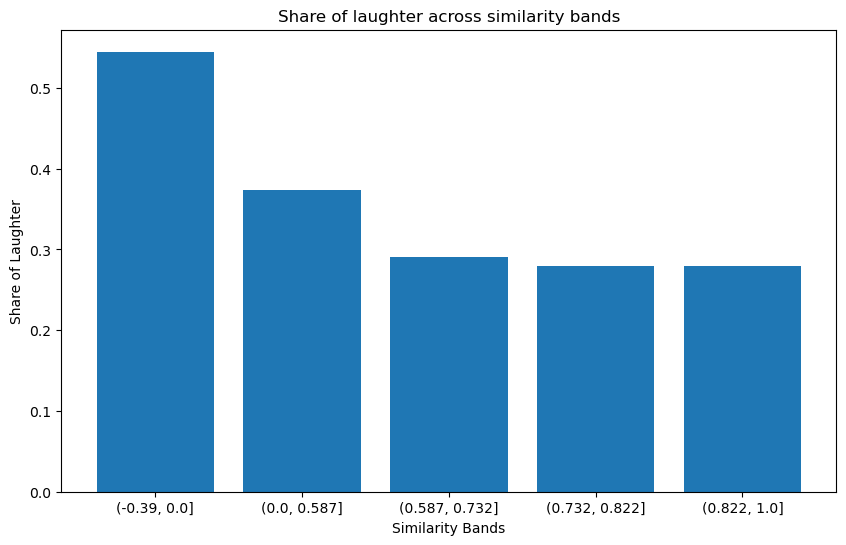

In [23]:
#temp = temp.reset_index()
import matplotlib.pyplot as plt

plt.figure(figsize = (10,6))
plt.bar(temp['cosine_sim_1'].astype(str),temp['laughter'])
plt.title('Share of laughter across similarity bands')
plt.xlabel('Similarity Bands')
plt.ylabel('Share of Laughter')
plt.show()

In [329]:
# Flatten the lists of labels, keeping track of laughter tags
entity_laughter = []
for labels, laughter in zip(combined_data['labels'], combined_data['laughter']):
    for label in labels:
        entity_laughter.append((label, laughter))

# Convert to a DataFrame for easy aggregation
entity_laughter_df = pd.DataFrame(entity_laughter, columns=['Entity', 'Laughter'])

# Calculate the share of laughter=1 for each entity type
entity_laughter_summary = (
    entity_laughter_df.groupby('Entity')['Laughter']
    .agg(['sum', 'count'])  # Sum of laughter=1 and total count
    .rename(columns={'sum': 'Laughter_Count', 'count': 'Total'})
)
entity_laughter_summary['Laughter_Share'] = entity_laughter_summary['Laughter_Count'] / entity_laughter_summary['Total']
entity_laughter_summary.sort_values(by = 'Total', ascending = False)

,Laughter_Count,Total,Laughter_Share
Entity,,,
CARDINAL,206,744,0.276882
DATE,151,613,0.246330
PERSON,162,450,0.360000
GPE,105,412,0.254854
TIME,77,231,0.333333
ORDINAL,53,199,0.266332
ORG,38,145,0.262069
NORP,41,142,0.288732
MONEY,36,107,0.336449


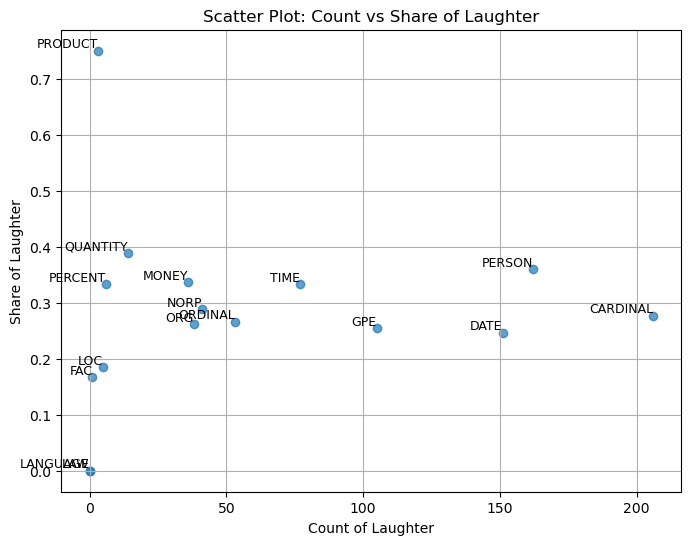

In [330]:
import matplotlib.pyplot as plt
# Scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(entity_laughter_summary['Laughter_Count'], entity_laughter_summary['Laughter_Share'], alpha=0.7)

# Adding labels to each point
for idx, row in entity_laughter_summary.iterrows():
    plt.text(row['Laughter_Count'], row['Laughter_Share'], idx, fontsize=9, ha='right', va='bottom')

# Labels and title
plt.xlabel('Count of Laughter')
plt.ylabel('Share of Laughter')
plt.title('Scatter Plot: Count vs Share of Laughter')
plt.grid(True)
plt.show()

In [27]:
temp = (combined_data.groupby(pd.qcut(combined_data['sense_combination'], q=5, duplicates = 'drop'))['laughter'].sum()/combined_data.groupby(pd.qcut(combined_data['sense_combination'], q=5, duplicates = 'drop'))['laughter'].count())

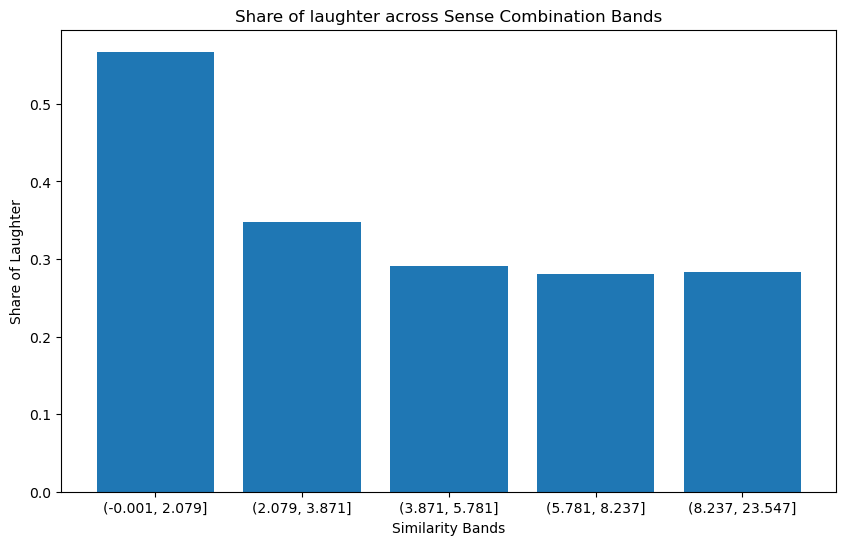

In [31]:
temp = temp.reset_index()
import matplotlib.pyplot as plt

plt.figure(figsize = (10,6))
plt.bar(temp['sense_combination'].astype(str),temp['laughter'])
plt.title('Share of laughter across Sense Combination Bands')
plt.xlabel('Similarity Bands')
plt.ylabel('Share of Laughter')
plt.show()

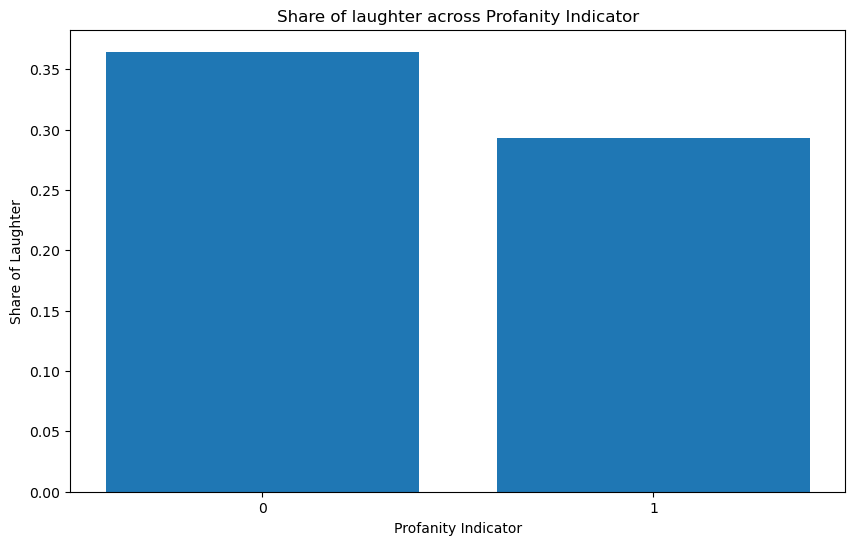

In [51]:
temp = combined_data.groupby(['profanity_flag']).agg({'laughter':'sum'})/combined_data.groupby(['profanity_flag']).agg({'laughter':'count'})
temp = temp.reset_index()


temp = temp.reset_index()
import matplotlib.pyplot as plt

plt.figure(figsize = (10,6))
plt.bar(temp['profanity_flag'].astype(str),temp['laughter'])
plt.title('Share of laughter across Profanity Indicator')
plt.xlabel('Profanity Indicator')
plt.ylabel('Share of Laughter')
plt.show()

C:\Users\taram\AppData\Local\Temp\ipykernel_23100\4041152503.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp = (combined_data.groupby(pd.qcut(combined_data['sense_closest'], q=5, duplicates = 'drop'))['laughter'].sum()/combined_data.groupby(pd.qcut(combined_data['sense_closest'], q=5, duplicates = 'drop'))['laughter'].count())
C:\Users\taram\AppData\Local\Temp\ipykernel_23100\4041152503.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp = (combined_data.groupby(pd.qcut(combined_data['sense_closest'], q=5, duplicates = 'drop'))['laughter'].sum()/combined_data.groupby(pd.qcut(combined_data['sense

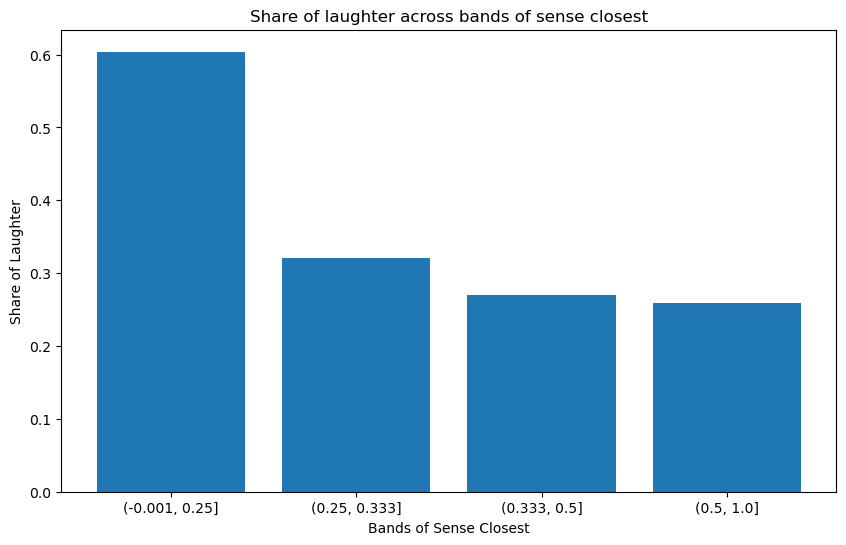

In [65]:
temp = (combined_data.groupby(pd.qcut(combined_data['sense_closest'], q=5, duplicates = 'drop'))['laughter'].sum()/combined_data.groupby(pd.qcut(combined_data['sense_closest'], q=5, duplicates = 'drop'))['laughter'].count())
temp = temp.reset_index()


temp = temp.reset_index()
import matplotlib.pyplot as plt

plt.figure(figsize = (10,6))
plt.bar(temp['sense_closest'].astype(str),temp['laughter'])
plt.title('Share of laughter across bands of sense closest')
plt.xlabel('Bands of Sense Closest')
plt.ylabel('Share of Laughter')
plt.show()

C:\Users\taram\AppData\Local\Temp\ipykernel_23100\3756789678.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  laughter_share = combined_data.groupby('sentiment_band')['laughter'].mean().reset_index()


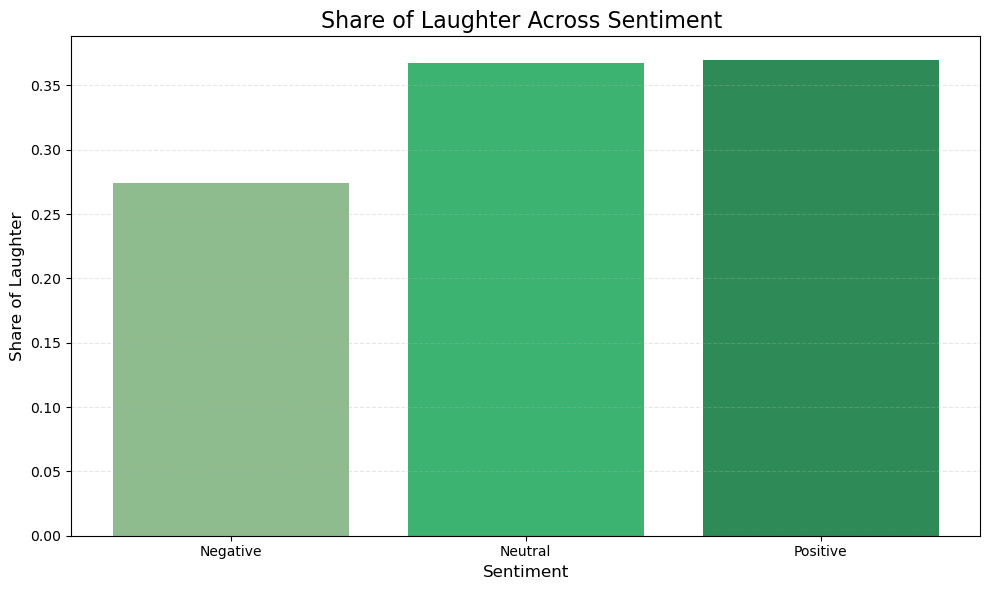

In [61]:
# Define new bins: Extreme Left, Center, Extreme Right
combined_data['sentiment_band'] = pd.cut(
    combined_data['sentiment_compound'], 
    bins=[-1.0, -0.33, 0.33, 1.0], 
    labels=["Negative", "Neutral", "Positive"]
)

# Calculate the share of laughter in each band
laughter_share = combined_data.groupby('sentiment_band')['laughter'].mean().reset_index()

# Plotting the bar plot with shades of green
plt.figure(figsize=(10, 6))
plt.bar(
    laughter_share['sentiment_band'], 
    laughter_share['laughter'], 
    color=['#8FBC8F', '#3CB371', '#2E8B57'],  # Shades of green
    
)
plt.title("Share of Laughter Across Sentiment ", fontsize=16)
plt.xlabel("Sentiment", fontsize=12)
plt.ylabel("Share of Laughter", fontsize=12)
plt.xticks(fontsize=10)
plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()



In [73]:
combined_data[combined_data['sense_closest']<=0.20]['text']

15       'cause he didn't explain what obvious would be.
18                                    in your ear canal.
25                               it was nothing obvious.
33                                          that was it.
34                                           no science.
                              ...                       
21669                  scared the shit out of everybody.
21673          and all of a sudden he was like, "hello."
21674                   and i was like, "ahh! (screams)"
21688                                if you don't mind."
21698                                  (audience laughs)
Name: text, Length: 3114, dtype: object

In [41]:
combined_data.groupby(['profanity_flag']).agg({'laughter':'count'})

,name
profanity_flag,
0,20190
1,1527


In [324]:
# number of unique video id

unique_video_ids = combined_data['video_id'].nunique()
print(f"Number of unique video IDs: {unique_video_ids}")

Number of unique video IDs: 38


**Model Building**


In [464]:
import pandas as pd
from sklearn.model_selection import train_test_split


# Unique video IDs
video_ids = combined_data['video_id'].unique()

# Split video IDs into training and testing groups
train_videos, test_videos = train_test_split(video_ids, test_size=0.2, random_state=42)

# Create training and testing datasets based on video_id
train_df = combined_data[combined_data['video_id'].isin(train_videos)]
test_df = combined_data[combined_data['video_id'].isin(test_videos)]

# Features and target
feature_columns = ['alliteration','assonance','consonance','avg_senses','antonym_count','profanity_flag','sentiment_compound','sense_combination','sense_farmost','sense_closest','question_count','exclamation_count','pause_count','entity_count','proper_noun_count','label_TIME','label_LANGUAGE','label_NORP','label_PERCENT','label_QUANTITY','label_FAC','label_LOC','label_PERSON','label_MONEY','label_GPE','label_DATE','label_CARDINAL','label_ORG','label_ORDINAL','label_LAW','label_PRODUCT',\
                   'prev_alliteration_1','prev_assonance_1','prev_consonance_1','prev_avg_senses_1','prev_antonym_count_1','prev_profanity_flag_1','prev_sentiment_compound_1','prev_sense_combination_1','prev_sense_farmost_1','prev_sense_closest_1','prev_question_count_1','prev_exclamation_count_1','prev_pause_count_1','prev_label_TIME_1','prev_label_LANGUAGE_1','prev_label_NORP_1','prev_label_PERCENT_1','prev_label_QUANTITY_1','prev_label_FAC_1','prev_label_LOC_1','prev_label_PERSON_1','prev_label_MONEY_1','prev_label_GPE_1','prev_label_DATE_1','prev_label_CARDINAL_1','prev_label_ORG_1','prev_label_ORDINAL_1','prev_label_LAW_1','prev_label_PRODUCT_1','prev_entity_count_1','prev_proper_noun_count_1',\
                   'prev_alliteration_2','prev_assonance_2','prev_consonance_2','prev_avg_senses_2','prev_antonym_count_2','prev_profanity_flag_2','prev_sentiment_compound_2','prev_sense_combination_2','prev_sense_farmost_2','prev_sense_closest_2','prev_question_count_2','prev_exclamation_count_2','prev_pause_count_2','prev_label_TIME_2','prev_label_LANGUAGE_2','prev_label_NORP_2','prev_label_PERCENT_2','prev_label_QUANTITY_2','prev_label_FAC_2','prev_label_LOC_2','prev_label_PERSON_2','prev_label_MONEY_2','prev_label_GPE_2','prev_label_DATE_2','prev_label_CARDINAL_2','prev_label_ORG_2','prev_label_ORDINAL_2','prev_label_LAW_2','prev_label_PRODUCT_2','prev_entity_count_2','prev_proper_noun_count_2',\
                   'prev_alliteration_3','prev_assonance_3','prev_consonance_3','prev_avg_senses_3','prev_antonym_count_3','prev_profanity_flag_3','prev_sentiment_compound_3','prev_sense_combination_3','prev_sense_farmost_3','prev_sense_closest_3','prev_question_count_3','prev_exclamation_count_3','prev_pause_count_3','prev_label_TIME_3','prev_label_LANGUAGE_3','prev_label_NORP_3','prev_label_PERCENT_3','prev_label_QUANTITY_3','prev_label_FAC_3','prev_label_LOC_3','prev_label_PERSON_3','prev_label_MONEY_3','prev_label_GPE_3','prev_label_DATE_3','prev_label_CARDINAL_3','prev_label_ORG_3','prev_label_ORDINAL_3','prev_label_LAW_3','prev_label_PRODUCT_3','prev_entity_count_3','prev_proper_noun_count_3',\
                   'prev_alliteration_4','prev_assonance_4','prev_consonance_4','prev_avg_senses_4','prev_antonym_count_4','prev_profanity_flag_4','prev_sentiment_compound_4','prev_sense_combination_4','prev_sense_farmost_4','prev_sense_closest_4','prev_question_count_4','prev_exclamation_count_4','prev_pause_count_4','prev_label_TIME_4','prev_label_LANGUAGE_4','prev_label_NORP_4','prev_label_PERCENT_4','prev_label_QUANTITY_4','prev_label_FAC_4','prev_label_LOC_4','prev_label_PERSON_4','prev_label_MONEY_4','prev_label_GPE_4','prev_label_DATE_4','prev_label_CARDINAL_4','prev_label_ORG_4','prev_label_ORDINAL_4','prev_label_LAW_4','prev_label_PRODUCT_4','prev_entity_count_4','prev_proper_noun_count_4',\
                   'prev_alliteration_5','prev_assonance_5','prev_consonance_5','prev_avg_senses_5','prev_antonym_count_5','prev_profanity_flag_5','prev_sentiment_compound_5','prev_sense_combination_5','prev_sense_farmost_5','prev_sense_closest_5','prev_question_count_5','prev_exclamation_count_5','prev_pause_count_5','prev_label_TIME_5','prev_label_LANGUAGE_5','prev_label_NORP_5','prev_label_PERCENT_5','prev_label_QUANTITY_5','prev_label_FAC_5','prev_label_LOC_5','prev_label_PERSON_5','prev_label_MONEY_5','prev_label_GPE_5','prev_label_DATE_5','prev_label_CARDINAL_5','prev_label_ORG_5','prev_label_ORDINAL_5','prev_label_LAW_5','prev_label_PRODUCT_5','prev_entity_count_5','prev_proper_noun_count_5',\
                   'cosine_sim_1','cosine_sim_2','cosine_sim_3','cosine_sim_4','cosine_sim_5']

X_train = train_df[feature_columns]
y_train = train_df['laughter']
X_test = test_df[feature_columns]
y_test = test_df['laughter']

# Check the sizes of the splits
print(f"Training set: {X_train.shape}, Testing set: {X_test.shape}")


Training set: (16668, 191), Testing set: (5049, 191)


In [466]:
# Verify the number of unique video IDs in train and test sets
print(f"Unique videos in training set: {train_df['video_id'].nunique()}")
print(f"Unique videos in testing set: {test_df['video_id'].nunique()}")


Unique videos in training set: 30
Unique videos in testing set: 8


In [468]:
# Check if rows within each video_id in train and test sets are sequential
def check_sequential_order(df, group_col, order_col):
    for video_id, group in df.groupby(group_col):
        if not group[order_col].is_monotonic_increasing:
            print(f"Rows for video_id {video_id} are not in order!")
            return False
    return True

# Verify sequential order in train and test sets
is_train_ordered = check_sequential_order(train_df, 'video_id', 'start_time')
is_test_ordered = check_sequential_order(test_df, 'video_id', 'start_time')

print(f"Train set rows are sequential: {is_train_ordered}")
print(f"Test set rows are sequential: {is_test_ordered}")


Train set rows are sequential: True
Test set rows are sequential: True


In [470]:
y_train.sum()/y_train.shape[0]

0.3865490760739141

In [472]:
y_test.sum()/y_test.shape[0]

0.26995444642503463

In [474]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

# Define hyperparameters for Decision Tree and Random Forest
dt_params = {
    'max_depth': [5, 10, 15, None]
}

rf_params = {
    'n_estimators': [100, 200, 500,1000]
}

# Initialize models
dt = DecisionTreeClassifier(random_state=42)
rf = RandomForestClassifier(random_state=42)

# GridSearchCV for Decision Tree
dt_grid = GridSearchCV(estimator=dt, param_grid=dt_params, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
dt_grid.fit(X_train, y_train)

# Best Decision Tree Model
best_dt = dt_grid.best_estimator_
print("Best parameters for Decision Tree:", dt_grid.best_params_)

# GridSearchCV for Random Forest
rf_grid = GridSearchCV(estimator=rf, param_grid=rf_params, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
rf_grid.fit(X_train, y_train)

# Best Random Forest Model
best_rf = rf_grid.best_estimator_
print("Best parameters for Random Forest:", rf_grid.best_params_)


# Evaluate both models on the test set
for model, name in zip([best_dt, best_rf], ["Decision Tree", "Random Forest"]):
    print(f"\n{name} Classification Report:")
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best parameters for Decision Tree: {'max_depth': 5}
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best parameters for Random Forest: {'n_estimators': 1000}

Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.99      0.87      3686
           1       0.87      0.26      0.40      1363

    accuracy                           0.79      5049
   macro avg       0.83      0.62      0.64      5049
weighted avg       0.81      0.79      0.75      5049

Confusion Matrix:
[[3631   55]
 [1004  359]]

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.97      0.87      3686
           1       0.79      0.28      0.42      1363

    accuracy                           0.79      5049
   macro avg       0.79      0.63      0.64      5049
weighted avg       0.79      0.79      0.75      5

In [475]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Define the XGBoost classifier
xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', use_label_encoder=False)

# Set up the parameter grid for 5-fold cross-validation
param_grid = {
    "learning_rate": [0.01, 0.1, 0.2],
    "max_depth": [3, 5, 7],
    "n_estimators": [50, 100, 200],
    "subsample": [0.8, 1.0]
}

# Perform GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring="roc_auc",
    cv=5,
    verbose=1,
    n_jobs=-1
)

# Fit the model to the training data
grid_search.fit(X_train, y_train)

# Get the best parameters and best model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print("Best Parameters:", best_params)

# Evaluate the best model on the test set
y_pred_proba = best_model.predict_proba(X_test)[:, 1]
y_pred = best_model.predict(X_test)

# Print classification report
print("Boosting Tree Classification Report:")
print(classification_report(y_test, y_pred))


Fitting 5 folds for each of 54 candidates, totalling 270 fits


/opt/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [16:54:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [16:54:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [16:54:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [16:54:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.11/site-packa

Best Parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
Boosting Tree Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.99      0.87      3686
           1       0.89      0.25      0.39      1363

    accuracy                           0.79      5049
   macro avg       0.84      0.62      0.63      5049
weighted avg       0.81      0.79      0.74      5049



/opt/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [16:54:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [476]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.99      0.87      3686
           1       0.89      0.25      0.39      1363

    accuracy                           0.79      5049
   macro avg       0.84      0.62      0.63      5049
weighted avg       0.81      0.79      0.74      5049



Decision Tree AUC: 0.6515
Random Forest AUC: 0.6874
XG Boost AUC: 0.6782


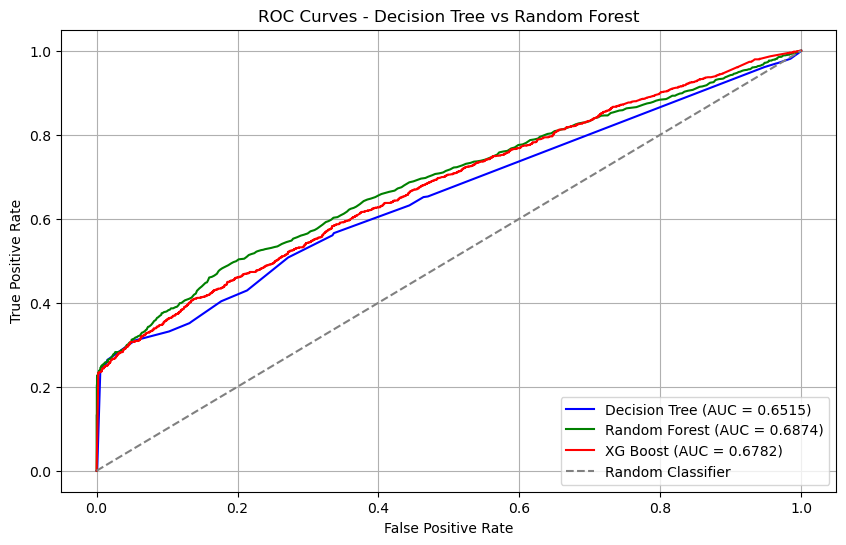

In [477]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Initialize the plot
plt.figure(figsize=(10, 6))

# Evaluate AUC for both models and plot on the same figure
for model, name, color in zip([best_dt, best_rf,best_model], ["Decision Tree", "Random Forest","XG Boost"], ["blue", "green","red"]):
    # Get predicted probabilities for the positive class
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Compute AUC
    auc = roc_auc_score(y_test, y_pred_proba)
    print(f"{name} AUC: {auc:.4f}")

    # Compute ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    
    # Plot ROC curve
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.4f})", color=color)

# Add diagonal reference line
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Random Classifier")

# Customize plot
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves - Decision Tree vs Random Forest")
plt.legend(loc="lower right")
plt.grid()
plt.show()



### Feature Importance

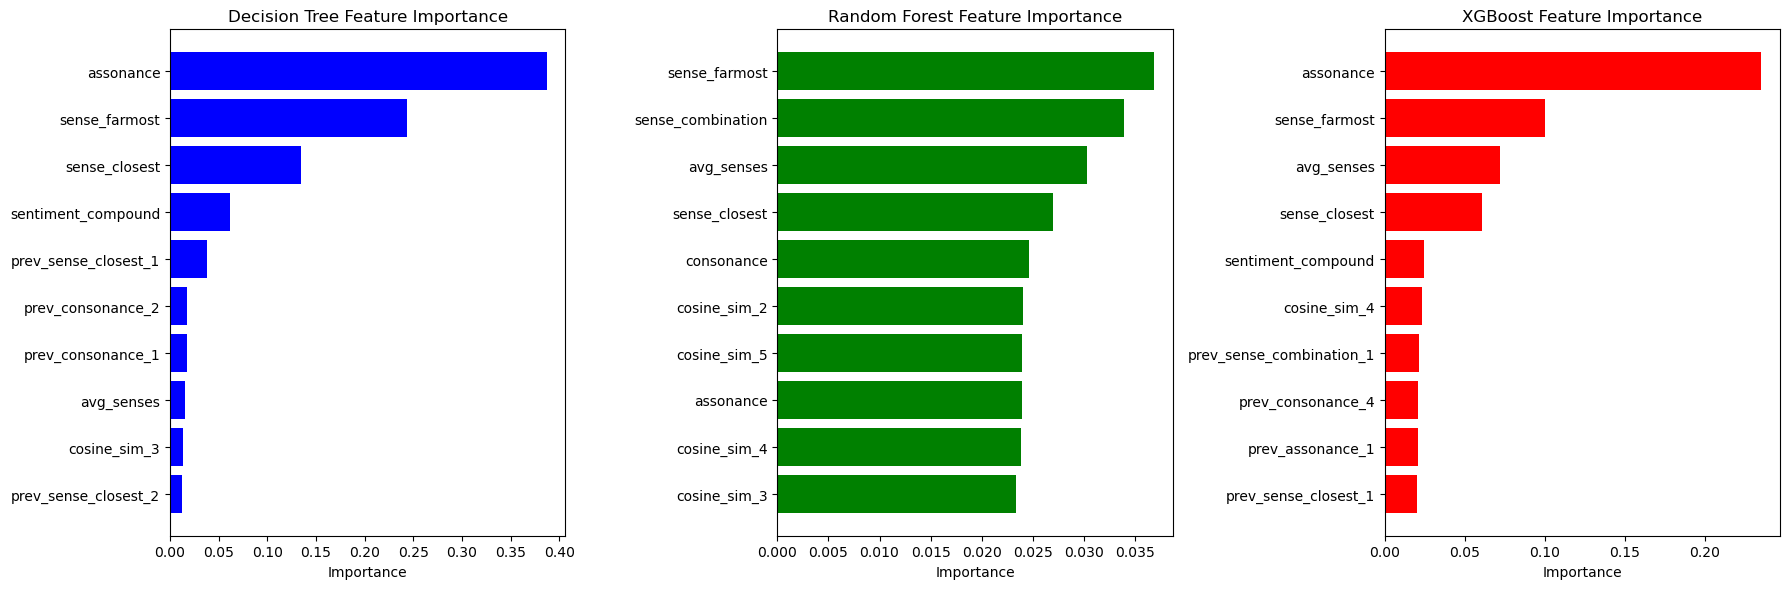

In [486]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Function to plot feature importance for Decision Tree, Random Forest, and XGBoost
def plot_feature_importances(models, model_names, feature_names, top_n=10):
    plt.figure(figsize=(18, 6))
    
    for i, (model, name, color) in enumerate(zip(models, model_names, ["blue", "green", "red"])):
        if hasattr(model, "feature_importances_"):  # Check if model has feature_importances_
            importances = model.feature_importances_
            sorted_idx = np.argsort(importances)[-top_n:]  # Get top_n feature indices
            sorted_features = feature_names[sorted_idx]
            sorted_importances = importances[sorted_idx]
            
            plt.subplot(1, 3, i + 1)
            plt.barh(sorted_features, sorted_importances, color=color)
            plt.xlabel("Importance")
            plt.title(f"{name} Feature Importance")
            plt.tight_layout()
    
    plt.show()

# Assuming X_train is a DataFrame
feature_names = X_train.columns

# Call the function with best_dt, best_rf, and best_model
plot_feature_importances(
    models=[best_dt, best_rf, best_model],
    model_names=["Decision Tree", "Random Forest", "XGBoost"],
    feature_names=feature_names
)

## Learning Curve

Processing sample size: 2
Processing sample size: 4
Processing sample size: 6
Processing sample size: 8
Processing sample size: 10
Processing sample size: 12
Processing sample size: 14
Processing sample size: 16
Processing sample size: 18
Processing sample size: 20
Processing sample size: 22
Processing sample size: 24
Processing sample size: 26
Processing sample size: 28
Processing sample size: 30
Processing sample size: 32
Processing sample size: 34


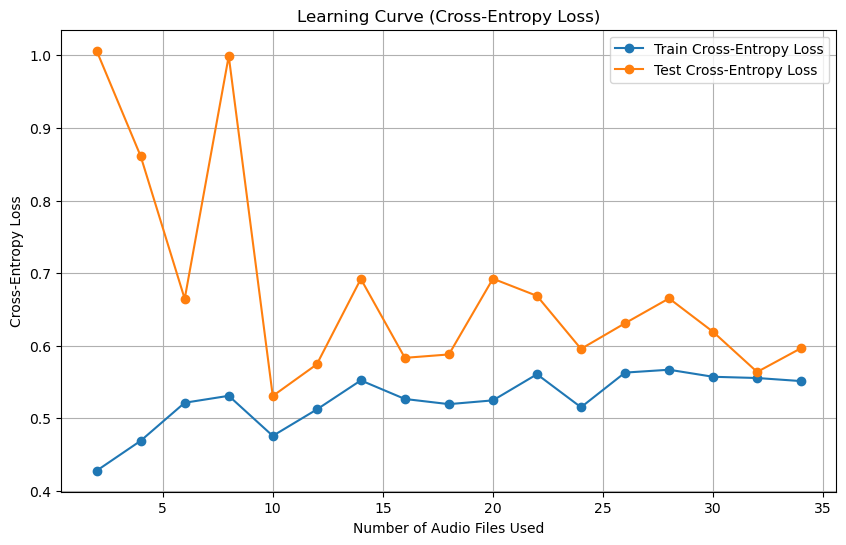

In [491]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import random
from sklearn.metrics import log_loss

# Initialize lists for storing train and test errors
train_errors = []
test_errors = []

# Sample sizes to evaluate
sample_sizes = list(range(2, 36, 2))


# Function to filter data by audio files
def get_data_for_audio_files(df, audio_files):
    filtered_df = combined_data[combined_data['video_id'].isin(audio_files)]
    feature_columns = ['alliteration','assonance','consonance','avg_senses','antonym_count','profanity_flag','sentiment_compound','sense_combination','sense_farmost','sense_closest','question_count','exclamation_count','pause_count','entity_count','proper_noun_count','label_TIME','label_LANGUAGE','label_NORP','label_PERCENT','label_QUANTITY','label_FAC','label_LOC','label_PERSON','label_MONEY','label_GPE','label_DATE','label_CARDINAL','label_ORG','label_ORDINAL','label_LAW','label_PRODUCT',\
                   'prev_alliteration_1','prev_assonance_1','prev_consonance_1','prev_avg_senses_1','prev_antonym_count_1','prev_profanity_flag_1','prev_sentiment_compound_1','prev_sense_combination_1','prev_sense_farmost_1','prev_sense_closest_1','prev_question_count_1','prev_exclamation_count_1','prev_pause_count_1','prev_label_TIME_1','prev_label_LANGUAGE_1','prev_label_NORP_1','prev_label_PERCENT_1','prev_label_QUANTITY_1','prev_label_FAC_1','prev_label_LOC_1','prev_label_PERSON_1','prev_label_MONEY_1','prev_label_GPE_1','prev_label_DATE_1','prev_label_CARDINAL_1','prev_label_ORG_1','prev_label_ORDINAL_1','prev_label_LAW_1','prev_label_PRODUCT_1','prev_entity_count_1','prev_proper_noun_count_1',\
                   'prev_alliteration_2','prev_assonance_2','prev_consonance_2','prev_avg_senses_2','prev_antonym_count_2','prev_profanity_flag_2','prev_sentiment_compound_2','prev_sense_combination_2','prev_sense_farmost_2','prev_sense_closest_2','prev_question_count_2','prev_exclamation_count_2','prev_pause_count_2','prev_label_TIME_2','prev_label_LANGUAGE_2','prev_label_NORP_2','prev_label_PERCENT_2','prev_label_QUANTITY_2','prev_label_FAC_2','prev_label_LOC_2','prev_label_PERSON_2','prev_label_MONEY_2','prev_label_GPE_2','prev_label_DATE_2','prev_label_CARDINAL_2','prev_label_ORG_2','prev_label_ORDINAL_2','prev_label_LAW_2','prev_label_PRODUCT_2','prev_entity_count_2','prev_proper_noun_count_2',\
                   'prev_alliteration_3','prev_assonance_3','prev_consonance_3','prev_avg_senses_3','prev_antonym_count_3','prev_profanity_flag_3','prev_sentiment_compound_3','prev_sense_combination_3','prev_sense_farmost_3','prev_sense_closest_3','prev_question_count_3','prev_exclamation_count_3','prev_pause_count_3','prev_label_TIME_3','prev_label_LANGUAGE_3','prev_label_NORP_3','prev_label_PERCENT_3','prev_label_QUANTITY_3','prev_label_FAC_3','prev_label_LOC_3','prev_label_PERSON_3','prev_label_MONEY_3','prev_label_GPE_3','prev_label_DATE_3','prev_label_CARDINAL_3','prev_label_ORG_3','prev_label_ORDINAL_3','prev_label_LAW_3','prev_label_PRODUCT_3','prev_entity_count_3','prev_proper_noun_count_3',\
                   'prev_alliteration_4','prev_assonance_4','prev_consonance_4','prev_avg_senses_4','prev_antonym_count_4','prev_profanity_flag_4','prev_sentiment_compound_4','prev_sense_combination_4','prev_sense_farmost_4','prev_sense_closest_4','prev_question_count_4','prev_exclamation_count_4','prev_pause_count_4','prev_label_TIME_4','prev_label_LANGUAGE_4','prev_label_NORP_4','prev_label_PERCENT_4','prev_label_QUANTITY_4','prev_label_FAC_4','prev_label_LOC_4','prev_label_PERSON_4','prev_label_MONEY_4','prev_label_GPE_4','prev_label_DATE_4','prev_label_CARDINAL_4','prev_label_ORG_4','prev_label_ORDINAL_4','prev_label_LAW_4','prev_label_PRODUCT_4','prev_entity_count_4','prev_proper_noun_count_4',\
                   'prev_alliteration_5','prev_assonance_5','prev_consonance_5','prev_avg_senses_5','prev_antonym_count_5','prev_profanity_flag_5','prev_sentiment_compound_5','prev_sense_combination_5','prev_sense_farmost_5','prev_sense_closest_5','prev_question_count_5','prev_exclamation_count_5','prev_pause_count_5','prev_label_TIME_5','prev_label_LANGUAGE_5','prev_label_NORP_5','prev_label_PERCENT_5','prev_label_QUANTITY_5','prev_label_FAC_5','prev_label_LOC_5','prev_label_PERSON_5','prev_label_MONEY_5','prev_label_GPE_5','prev_label_DATE_5','prev_label_CARDINAL_5','prev_label_ORG_5','prev_label_ORDINAL_5','prev_label_LAW_5','prev_label_PRODUCT_5','prev_entity_count_5','prev_proper_noun_count_5',\
                   'cosine_sim_1','cosine_sim_2','cosine_sim_3','cosine_sim_4','cosine_sim_5']
    
    X = filtered_df[feature_columns]
    y = filtered_df['laughter']

    return X, y

# Loop through each sample size
for sample_size in sample_sizes:
    print(f"Processing sample size: {sample_size}")

    # Randomly sample audio file names
    sampled_audio_files = random.sample(combined_data['video_id'].unique().tolist(), sample_size)

    # Prepare data for sampled audio files
    X, y = get_data_for_audio_files(combined_data, sampled_audio_files)

    # Split into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    
    # Fit the Decision Tree model
    model = DecisionTreeClassifier(max_depth=5, random_state=42)
    model.fit(X_train, y_train)

     # Compute train and test errors (cross-entropy loss)
    train_proba = model.predict_proba(X_train)
    test_proba = model.predict_proba(X_test)

    train_error = log_loss(y_train, train_proba)
    test_error = log_loss(y_test, test_proba)

    train_errors.append(train_error)
    test_errors.append(test_error)


# Plot learning curve
plt.figure(figsize=(10, 6))
plt.plot(sample_sizes, train_errors, label="Train Cross-Entropy Loss", marker="o")
plt.plot(sample_sizes, test_errors, label="Test Cross-Entropy Loss", marker="o")
plt.xlabel("Number of Audio Files Used")
plt.ylabel("Cross-Entropy Loss")
plt.title("Learning Curve (Cross-Entropy Loss)")
plt.legend()
plt.grid()
plt.show()

In [495]:
best_model


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.01, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [499]:
best_dt

DecisionTreeClassifier(max_depth=5, random_state=42)

In [505]:
import joblib

# Paths to save the models
dt_model_path = "best_dt_model_text.joblib"
rf_model_path = "best_rf_model_text.joblib"
best_model_path = "best_model_text.joblib"

# Export the models using joblib
joblib.dump(best_dt, dt_model_path)
joblib.dump(best_rf, rf_model_path)
joblib.dump(best_model, best_model_path)

print(f"Models saved as:\n- {dt_model_path}\n- {rf_model_path}\n- {best_model_path}")

Models saved as:
- best_dt_model_text.joblib
- best_rf_model_text.joblib
- best_model_text.joblib


## Performance on Old models (w/o lookback and profanity checks)

Accuracy: 0.6715591248961507

Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.84      0.76      2229
           1       0.61      0.40      0.48      1382

    accuracy                           0.67      3611
   macro avg       0.65      0.62      0.62      3611
weighted avg       0.66      0.67      0.65      3611



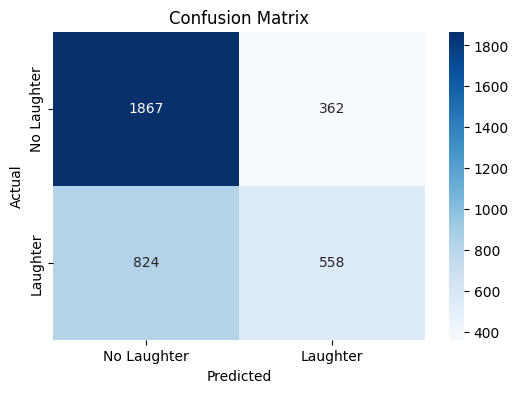

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Train Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')  # Handles class imbalance
rf_model.fit(X_train, y_train)

# Predict on Test Set
y_pred = rf_model.predict(X_test)

# Evaluate Model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Laughter', 'Laughter'], yticklabels=['No Laughter', 'Laughter'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


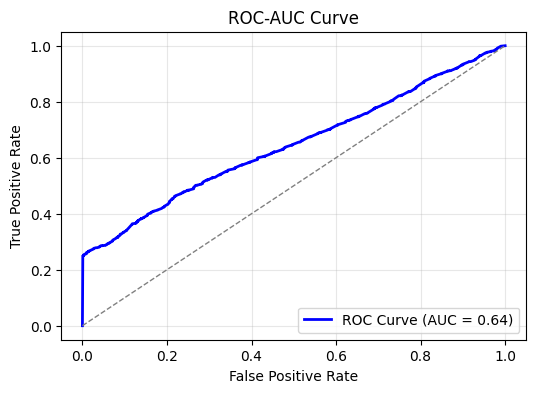

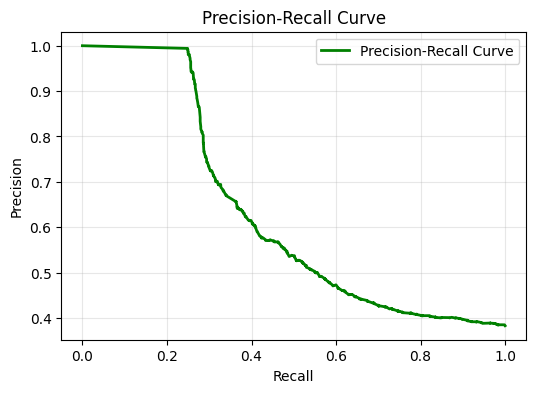

In [ ]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve

# Predict probabilities for the positive class (class 1: Laughter)
y_probs = rf_model.predict_proba(X_test)[:, 1]

# ROC-AUC Curve
fpr, tpr, _ = roc_curve(y_test, y_probs)  # Compute False Positive Rate and True Positive Rate
roc_auc = auc(fpr, tpr)  # Compute Area Under the Curve

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='blue', lw=2, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')  # Random chance line
plt.title("ROC-AUC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_probs)

plt.figure(figsize=(6, 4))
plt.plot(recall, precision, color='green', lw=2, label="Precision-Recall Curve")
plt.title("Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc="upper right")
plt.grid(alpha=0.3)
plt.show()


In [ ]:
# Check class distribution in the training set
majority_class = y_train.value_counts().idxmax()  # The class with the most occurrences
majority_class_proportion = y_train.value_counts().max() / len(y_train)  # Proportion of the majority class

# Print baseline accuracy
print(f"Baseline Accuracy (Majority Class): {majority_class_proportion:.2f}")
print(f"Majority Class: {majority_class}")


Baseline Accuracy (Majority Class): 0.65
Majority Class: 0


Accuracy: 0.6887288839656605

Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.87      0.78      2229
           1       0.66      0.39      0.49      1382

    accuracy                           0.69      3611
   macro avg       0.68      0.63      0.63      3611
weighted avg       0.68      0.69      0.67      3611



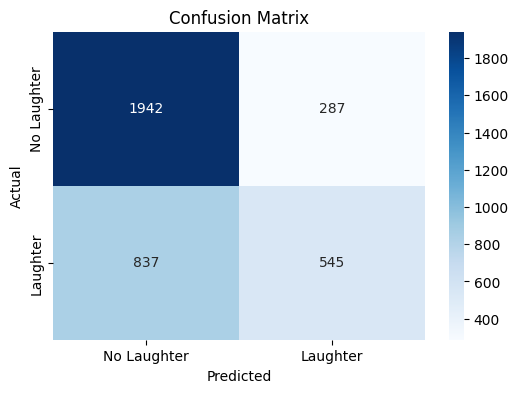

In [ ]:
## XGBoost model

from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Train XGBoost model
xgb_model = XGBClassifier(
    scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1]),  # Handle imbalance
    n_estimators=100,  # Number of trees
    max_depth=6,       # Max depth of trees
    learning_rate=0.1, # Learning rate
    random_state=42
)

xgb_model.fit(X_train, y_train)

# Predict on the test set
y_pred = xgb_model.predict(X_test)
y_probs = xgb_model.predict_proba(X_test)[:, 1]  # Predicted probabilities for class 1

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Laughter', 'Laughter'], yticklabels=['No Laughter', 'Laughter'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [ ]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.2],
    'scale_pos_weight': [1, len(y_train[y_train == 0]) / len(y_train[y_train == 1])]
}

# Perform grid search
grid_search = GridSearchCV(estimator=XGBClassifier(random_state=42), param_grid=param_grid, scoring='f1', cv=3, verbose=1)
grid_search.fit(X_train, y_train)

# Best parameters
print("Best Parameters:", grid_search.best_params_)


Fitting 3 folds for each of 54 candidates, totalling 162 fits
Best Parameters: {'learning_rate': 0.2, 'max_depth': 6, 'n_estimators': 200, 'scale_pos_weight': 1.8212342608425307}


In [ ]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],          # Number of trees
    'max_depth': [3, 6, 9],                 # Tree depth
    'learning_rate': [0.01, 0.1, 0.2],      # Learning rate (eta)
    'min_child_weight': [1, 3, 5],          # Minimum child weight
    'gamma': [0, 0.1, 0.2],                 # Minimum loss reduction
    'scale_pos_weight': [1, len(y_train[y_train == 0]) / len(y_train[y_train == 1])]  # For class imbalance
}

# Instantiate the XGBoost Classifier
xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

# Perform grid search
grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring='f1',      # Optimize for F1-score
    cv=3,              # 3-fold cross-validation
    verbose=1,
    n_jobs=-1          # Use all CPU cores
)

# Fit grid search on training data
grid_search.fit(X_train, y_train)

# Print the best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best F1-Score:", grid_search.best_score_)

# Use the best model from grid search
xgb_f1_model = grid_search.best_estimator_

# Evaluate the best model on the test set
y_pred = xgb_f1_model.predict(X_test)
print("\nClassification Report for Best Model:")
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))


Fitting 3 folds for each of 486 candidates, totalling 1458 fits


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [23:11:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best Parameters: {'gamma': 0, 'learning_rate': 0.2, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 200, 'scale_pos_weight': 1.8212342608425307}
Best F1-Score: 0.4635354679217734

Classification Report for Best Model:
              precision    recall  f1-score   support

           0       0.70      0.79      0.74      2229
           1       0.58      0.46      0.51      1382

    accuracy                           0.66      3611
   macro avg       0.64      0.63      0.63      3611
weighted avg       0.66      0.66      0.66      3611



In [ ]:
## optimizing for accuracy

from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],          # Number of trees
    'max_depth': [3, 6, 9],                 # Tree depth
    'learning_rate': [0.01, 0.1, 0.2],      # Learning rate (eta)
    'min_child_weight': [1, 3, 5],          # Minimum child weight
    'gamma': [0, 0.1, 0.2],                 # Minimum loss reduction
    'scale_pos_weight': [1, len(y_train[y_train == 0]) / len(y_train[y_train == 1])]  # For class imbalance
}

# Instantiate the XGBoost Classifier
xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

# Perform grid search
grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring='accuracy',      # Optimize for F1-score
    cv=3,              # 3-fold cross-validation
    verbose=1,
    n_jobs=-1          # Use all CPU cores
)

# Fit grid search on training data
grid_search.fit(X_train, y_train)

# Print the best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best F1-Score:", grid_search.best_score_)

# Use the best model from grid search
best_model = grid_search.best_estimator_

# Evaluate the best model on the test set
y_pred = best_model.predict(X_test)
print("\nClassification Report for Best Model:")
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))


Fitting 3 folds for each of 486 candidates, totalling 1458 fits
Best Parameters: {'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 50, 'scale_pos_weight': 1}
Best F1-Score: 0.728359125907932

Classification Report for Best Model:
              precision    recall  f1-score   support

           0       0.68      0.99      0.81      2229
           1       0.94      0.26      0.40      1382

    accuracy                           0.71      3611
   macro avg       0.81      0.62      0.60      3611
weighted avg       0.78      0.71      0.65      3611



/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:52:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


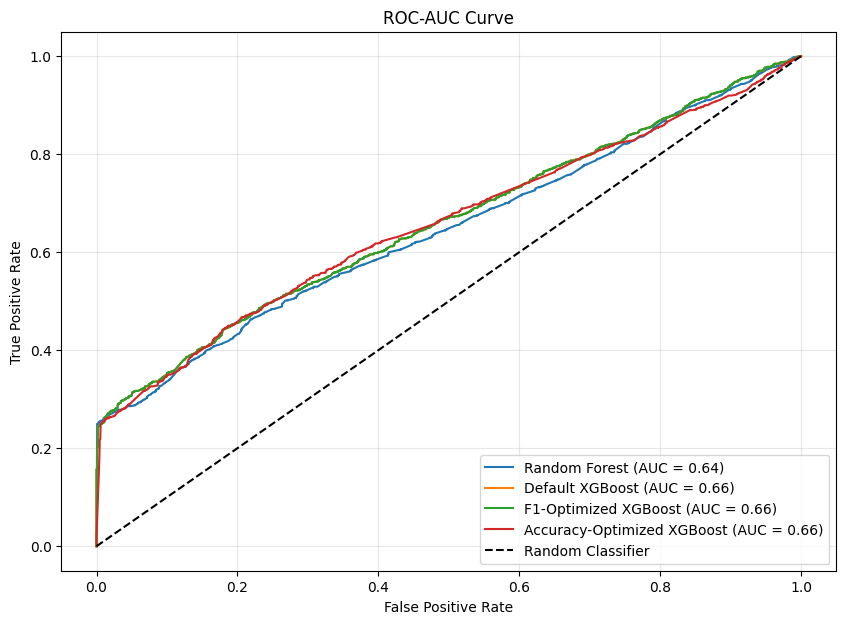

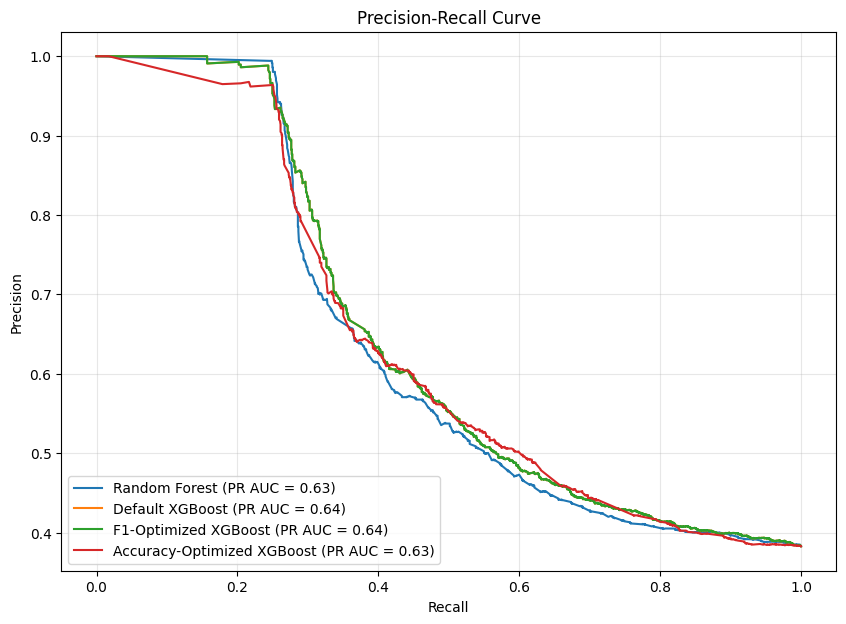

In [ ]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# Store results for each model
results = {}

# Helper function to compute metrics and store results
def evaluate_model(name, model, X_test, y_test):
    # Predict probabilities
    y_probs = model.predict_proba(X_test)[:, 1]

    # Compute ROC-AUC
    fpr, tpr, _ = roc_curve(y_test, y_probs)
    roc_auc = auc(fpr, tpr)

    # Compute Precision-Recall AUC
    precision, recall, _ = precision_recall_curve(y_test, y_probs)
    pr_auc = average_precision_score(y_test, y_probs)

    # Predict labels for accuracy
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    # Store results
    results[name] = {
        'ROC-AUC': roc_auc,
        'Precision-Recall AUC': pr_auc,
        'Accuracy': accuracy,
        'FPR': fpr,
        'TPR': tpr,
        'Precision': precision,
        'Recall': recall
    }

# Evaluate Random Forest
evaluate_model("Random Forest", rf_model, X_test, y_test)

# Evaluate Default XGBoost
evaluate_model("Default XGBoost", xgb_model, X_test, y_test)

# Evaluate F1-Optimized XGBoost
evaluate_model("F1-Optimized XGBoost", xgb_f1_model, X_test, y_test)

# Evaluate Accuracy-Optimized XGBoost
evaluate_model("Accuracy-Optimized XGBoost", best_model, X_test, y_test)

# Plot ROC-AUC Curves
plt.figure(figsize=(10, 7))
for name, result in results.items():
    plt.plot(result['FPR'], result['TPR'], label=f"{name} (AUC = {result['ROC-AUC']:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier")
plt.title("ROC-AUC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

# Plot Precision-Recall Curves
plt.figure(figsize=(10, 7))
for name, result in results.items():
    plt.plot(result['Recall'], result['Precision'], label=f"{name} (PR AUC = {result['Precision-Recall AUC']:.2f})")
plt.title("Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc="lower left")
plt.grid(alpha=0.3)
plt.show()


In [ ]:
# Create a DataFrame for the results
summary_df = pd.DataFrame.from_dict(results, orient='index').reset_index()
summary_df = summary_df.rename(columns={
    'index': 'Model',
    'ROC-AUC': 'ROC-AUC Score',
    'Precision-Recall AUC': 'PR AUC Score',
    'Accuracy': 'Accuracy Score'
})

In [ ]:
# Select and display only the required columns
new_summary_df = summary_df[['Model', 'ROC-AUC Score', 'PR AUC Score', 'Accuracy Score']]
new_summary_df

,Model,ROC-AUC Score,PR AUC Score,Accuracy Score
0,Random Forest,0.644951,0.629332,0.671559
1,Default XGBoost,0.658688,0.642584,0.664636
2,F1-Optimized XGBoost,0.658688,0.642584,0.664636
3,Accuracy-Optimized XGBoost,0.656107,0.630825,0.708391
